<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [ ]:
!pip install gdown -q

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=143db07d-b2b9-4d6c-9df5-2857af455b27
To: /content/Data.zip
100%|██████████| 289M/289M [00:07<00:00, 39.2MB/s]


'Data.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
!pip install optuna
!pip install catboost
!pip install causalml -q
%pip install "scikit-learn==1.3.2" "scikit-uplift" "causalml"

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import causalml

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, make_uplift_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
import optuna

from catboost import CatBoostClassifier

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [ ]:
# выгрузим данные
people = pd.read_csv("/content/ДЗ по Uplift обновленное/PEOPLE_IN_CAMPAINGS_FINAL.csv", index_col=0)
cam = pd.read_csv("/content/ДЗ по Uplift обновленное/CAMPAINGS.csv", index_col=0)
contract = pd.read_csv("/content/ДЗ по Uplift обновленное/CONTRACTS_FINAL.csv", index_col=0)
aggs= pd.read_csv("/content/ДЗ по Uplift обновленное/AGGS_FINAL.csv", index_col=0)

In [ ]:
# посмтрим на данные
people.head()

campaing_id  user_id  t_flag delivery_date
29299       idclip  1099975       1    2024-11-06
36627        iddqd     1162       1    2024-11-08
134015       iddqd    42991       1    2024-11-07
57441       idclip   142343       0       unknown
48671        iddqd    24623       0       unknown

In [ ]:
people.tail()

campaing_id  user_id  t_flag delivery_date
107125        iddt  4108275       1    2024-11-04
36366        iddqd   131927       1    2024-11-06
98578       idclip  1074765       1    2024-11-05
14272        iddqd    73995       0       unknown
148522       iddqd    85450       1    2024-11-04

In [ ]:
contract.head()

user_id contract_date  product_id              contract_id
39735   4008279    2024-11-03           1  0001_2024-11-03_4008279
44062   2079035    2024-11-08           1  0001_2024-11-08_2079035
9286     103088    2024-11-13           1   0001_2024-11-13_103088
45573   2026788    2024-11-02           1  0001_2024-11-02_2026788
150378    52269    2024-11-17           1    0001_2024-11-17_52269

In [ ]:
contract.tail()

user_id contract_date  product_id              contract_id
34316   1117397    2024-11-28           1  0001_2024-11-28_1117397
101067  2071348    2024-11-12           1  0001_2024-11-12_2071348
5389    4061197    2024-11-07           1  0001_2024-11-07_4061197
33660   1139038    2024-11-02           1  0001_2024-11-02_1139038
30945   2023661    2024-11-02           1  0001_2024-11-02_2023661

In [ ]:
cam.head()

campaing_id  product_id    channel
0       iddqd           1       push
1      idclip           1        sms
2        iddt           1     banner
3       idkfa           1  other_ads

In [ ]:
aggs.head()

x1        x2        x3        x4        x5        x6        x7  \
104548  0.654343 -1.439286 -0.011475  2.039457  0.843580 -0.977480 -0.768019   
38396   2.583579  1.755569  3.360186 -1.122864  0.034201 -0.269607 -1.503646   
227077  0.296030 -0.937075  1.073280  1.874636 -0.981216 -1.100187 -0.331181   
304649  2.329328 -1.345159  0.345066  0.755373 -0.082842  0.028439  0.919211   
239518  0.167643  1.587099  0.165357  0.289758 -1.108840 -1.501819  0.615588   

              x8        x9   report_dt  user_id  age    city  
104548 -1.044127  0.025673  2025-01-31  1066338   26     Ufa  
38396   1.040289 -1.691606  2024-11-30    13900   35     Ufa  
227077 -1.575637  0.474965  2025-03-31  4063636   28     Ufa  
304649  0.808793 -0.560004  2025-03-31  1025488   27  Moscow  
239518  1.631203 -0.208419  2025-02-28  4040555   37  Moscow

In [ ]:
aggs.tail()

x1        x2        x3        x4        x5        x6        x7  \
100191  0.311284 -0.232406 -0.208223  1.006051 -1.498279  0.306518  1.135627   
342943 -1.970020  1.180142 -0.572525  1.052022 -0.654687  0.744590 -2.342623   
186830  0.403995 -0.350153 -0.584462  0.123843 -1.015746  0.922963  1.549083   
76230   2.218275 -0.344427  1.281239  3.781907  3.658907  1.282129  0.324350   
454256  0.289840  1.089333 -1.081154  0.259124 -1.985497  1.429450 -2.007802   

              x8        x9   report_dt  user_id  age      city  
100191  1.169791 -0.106392  2025-02-28    61957   38       Ufa  
342943 -0.136155  0.582400  2025-01-31   132172   40    Moscow  
186830  1.210031 -0.706992  2025-03-31  4028256   34  Smolensk  
76230   0.982721  2.046261  2025-02-28  1097844   40  Smolensk  
454256 -0.091926  1.052896  2025-01-31  2059711   45    Moscow

In [ ]:
# глянем размерность и пропуспуски по people
people.shape

(520000, 4)

In [ ]:
people['delivery_date'].isna().sum()

0

In [ ]:
cam['product_id'].unique()

array([1])

In [ ]:
people_cam = people.merge(cam, on="campaing_id", how="left")
people_cam.head()

campaing_id  user_id  t_flag delivery_date  product_id channel
0      idclip  1099975       1    2024-11-06           1     sms
1       iddqd     1162       1    2024-11-08           1    push
2       iddqd    42991       1    2024-11-07           1    push
3      idclip   142343       0       unknown           1     sms
4       iddqd    24623       0       unknown           1    push

In [ ]:
# замержим данные дропним столбец и переименуем его
people_contract = people_cam.merge(contract[contract['product_id']==1], on="user_id", how="left")
people_contract = people_contract.drop('product_id_x', axis=1)
people_contract = people_contract.rename(columns={'product_id_y': 'product_id'})

In [ ]:
people_contract

campaing_id  user_id  t_flag delivery_date channel contract_date  \
0           idclip  1099975       1    2024-11-06     sms    2024-11-11   
1            iddqd     1162       1    2024-11-08    push    2024-11-13   
2            iddqd    42991       1    2024-11-07    push           NaN   
3           idclip   142343       0       unknown     sms    2024-11-17   
4            iddqd    24623       0       unknown    push           NaN   
...            ...      ...     ...           ...     ...           ...   
519995        iddt  4108275       1    2024-11-04  banner    2024-11-15   
519996       iddqd   131927       1    2024-11-06    push    2024-11-27   
519997      idclip  1074765       1    2024-11-05     sms           NaN   
519998       iddqd    73995       0       unknown    push           NaN   
519999       iddqd    85450       1    2024-11-04    push    2024-11-17   

        product_id              contract_id  
0              1.0  0001_2024-11-11_1099975  
1              1.0     0001_2024-11-13_1162  
2              NaN                      NaN  
3              1.0   0001_2024-11-17_142343  
4              NaN                      NaN  
...            ...                      ...  
519995         1.0  0001_2024-11-15_4108275  
519996         1.0   0001_2024-11-27_131927  
519997         NaN                      NaN  
519998         NaN                      NaN  
519999         1.0    0001_2024-11-17_85450  

[520000 rows x 8 columns]

In [ ]:
# день старта компании (спрашивал гпт чат написания данной функции)
people_contract["contract_date"] = pd.to_datetime(people_contract["contract_date"], errors='coerce')
people_contract["delivery_date"] = pd.to_datetime(people_contract["delivery_date"], errors='coerce')

def define_target(row):
    if pd.isna(row["contract_date"]):
        return 0

    if row["t_flag"] == 1:
        if not pd.isna(row["delivery_date"]) and row["delivery_date"] <= row["contract_date"] <= row["delivery_date"] + pd.Timedelta(days=14):
            return 1
    else:
        if pd.isna(row["delivery_date"]):
            start_of_campaign = pd.Timestamp(year=row["contract_date"].year, month=row["contract_date"].month, day=1)
            if start_of_campaign <= row["contract_date"] <= start_of_campaign + pd.Timedelta(days=21):
                return 1

    return 0

people_contract["target"] = people_contract.apply(define_target, axis=1)

In [ ]:
people_contract

campaing_id  user_id  t_flag delivery_date channel contract_date  \
0           idclip  1099975       1    2024-11-06     sms    2024-11-11   
1            iddqd     1162       1    2024-11-08    push    2024-11-13   
2            iddqd    42991       1    2024-11-07    push           NaT   
3           idclip   142343       0           NaT     sms    2024-11-17   
4            iddqd    24623       0           NaT    push           NaT   
...            ...      ...     ...           ...     ...           ...   
519995        iddt  4108275       1    2024-11-04  banner    2024-11-15   
519996       iddqd   131927       1    2024-11-06    push    2024-11-27   
519997      idclip  1074765       1    2024-11-05     sms           NaT   
519998       iddqd    73995       0           NaT    push           NaT   
519999       iddqd    85450       1    2024-11-04    push    2024-11-17   

        product_id              contract_id  target  
0              1.0  0001_2024-11-11_1099975       1  
1              1.0     0001_2024-11-13_1162       1  
2              NaN                      NaN       0  
3              1.0   0001_2024-11-17_142343       1  
4              NaN                      NaN       0  
...            ...                      ...     ...  
519995         1.0  0001_2024-11-15_4108275       1  
519996         1.0   0001_2024-11-27_131927       0  
519997         NaN                      NaN       0  
519998         NaN                      NaN       0  
519999         1.0    0001_2024-11-17_85450       1  

[520000 rows x 9 columns]

In [ ]:
grouping = people_contract.groupby(["channel", "t_flag"]).agg(mean_target=("target", "mean"))

In [ ]:
grouping

mean_target
channel   t_flag             
banner    0          0.400733
          1          0.602717
other_ads 0          0.400733
          1          0.602717
push      0          0.202150
          1          0.601738
sms       0          0.684917
          1          0.201167

In [ ]:
# Расчитаем профитность аплифта
uplift_analys = people_contract.groupby("channel").agg(mean_treatment=("target", lambda x: x[people_contract["t_flag"] == 1].mean()),
    mean_control=("target", lambda x: x[people_contract["t_flag"] == 0].mean())).reset_index()

uplift_analys["uplift"] = uplift_analys["mean_treatment"] - uplift_analys["mean_control"]
uplift_analys = uplift_analys.sort_values(by="uplift", ascending=False)


In [ ]:
uplift_analys

channel  mean_treatment  mean_control    uplift
2       push        0.601738      0.202150  0.399588
0     banner        0.602717      0.400733  0.201983
1  other_ads        0.602717      0.400733  0.201983
3        sms        0.201167      0.684917 -0.483750

In [ ]:
# создадим столбец report_dt чтобы джойнить с агрегатами
people_contract['report_dt'] = pd.to_datetime('2024-11-01')

In [ ]:
people_contract.head()

campaing_id  user_id  t_flag delivery_date channel contract_date  \
0      idclip  1099975       1    2024-11-06     sms    2024-11-11   
1       iddqd     1162       1    2024-11-08    push    2024-11-13   
2       iddqd    42991       1    2024-11-07    push           NaT   
3      idclip   142343       0           NaT     sms    2024-11-17   
4       iddqd    24623       0           NaT    push           NaT   

   product_id              contract_id  target  report_dt  
0         1.0  0001_2024-11-11_1099975       1 2024-11-01  
1         1.0     0001_2024-11-13_1162       1 2024-11-01  
2         NaN                      NaN       0 2024-11-01  
3         1.0   0001_2024-11-17_142343       1 2024-11-01  
4         NaN                      NaN       0 2024-11-01

### ваши выводы здесь

*  СМС имеет отрицательный показатель -48% :(
*  Пуш уведы достигают аж до 40%



<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [ ]:
# Подвинем наш датасет на 2 месеяца назад
people_contract["report_dt"] = people_contract["report_dt"] - pd.DateOffset(months=2)

In [ ]:
aggs["report_dt"] = pd.to_datetime(aggs["report_dt"])
aggs["report_dt"] = aggs["report_dt"].dt.to_period("M").dt.to_timestamp()

In [ ]:
df = people_contract.merge(aggs, on=["user_id", "report_dt"], how="left")

In [ ]:
df.head()

campaing_id  user_id  t_flag delivery_date channel contract_date  \
0      idclip  1099975       1    2024-11-06     sms    2024-11-11   
1       iddqd     1162       1    2024-11-08    push    2024-11-13   
2       iddqd    42991       1    2024-11-07    push           NaT   
3      idclip   142343       0           NaT     sms    2024-11-17   
4       iddqd    24623       0           NaT    push           NaT   

   product_id              contract_id  target  report_dt  ...        x2  \
0         1.0  0001_2024-11-11_1099975       1 2024-09-01  ...  1.233201   
1         1.0     0001_2024-11-13_1162       1 2024-09-01  ...  1.688111   
2         NaN                      NaN       0 2024-09-01  ...  1.368764   
3         1.0   0001_2024-11-17_142343       1 2024-09-01  ...  2.449667   
4         NaN                      NaN       0 2024-09-01  ... -0.354332   

         x3        x4        x5        x6        x7        x8        x9  age  \
0 -1.000185  2.585873 -0.584520 -0.268274 -0.727814  1.606372  1.814158   42   
1  0.150933  3.230149 -0.189105  0.551481 -1.229590  1.159411 -0.085720   39   
2  1.841319 -1.529691 -0.608003 -1.116932  1.178124 -0.884607 -1.726070   43   
3  1.131850  1.021660 -1.212641  0.958422  1.039261 -0.964264 -2.225545   39   
4  1.288191 -2.754188  0.202581  0.831745 -0.002779 -1.463527  1.976755   39   

       city  
0    Moscow  
1    Moscow  
2    Moscow  
3  Smolensk  
4       Ufa  

[5 rows x 21 columns]

In [ ]:
# приступим к часте с EDA
cols = ['target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']
df.select_dtypes(['int', 'float']).groupby(by='t_flag').mean()[cols]

target        x1        x2        x3        x4        x5        x6  \
t_flag                                                                         
0       0.405212  0.234673  0.072202  0.624548 -0.419246  0.324341 -0.001771   
1       0.509750  0.238778  0.080618  0.629740 -0.415473  0.323701 -0.000478   

              x7        x8        x9        age  
t_flag                                           
0       0.153682  0.153069  0.177215  32.514127  
1       0.152902  0.151971  0.176007  32.491838

In [ ]:
names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']

In [ ]:
def plot_histograms(df, names, hue_column='t_flag', palette='Set2'):
    """
    Функция для построения гистограмм для каждого столбца в списке x_names.
    """
    for col in names:
        sns.histplot(data=df, x=col, hue=hue_column, palette=palette)
        plt.title(cols)
        plt.show()

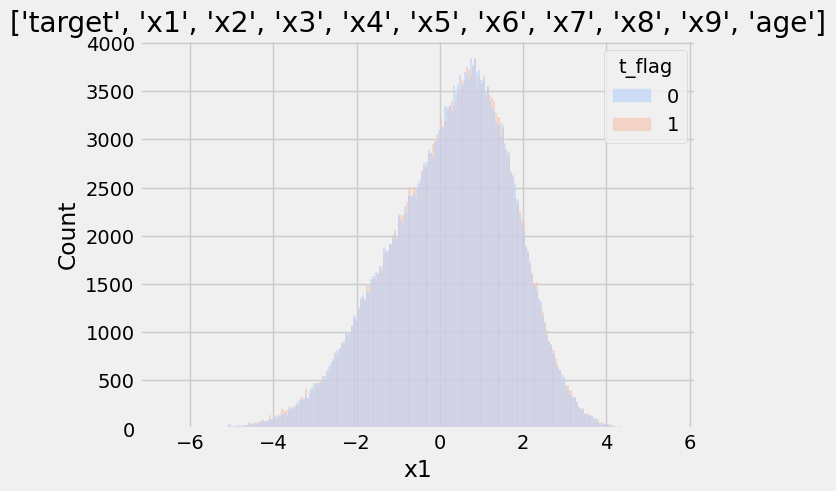

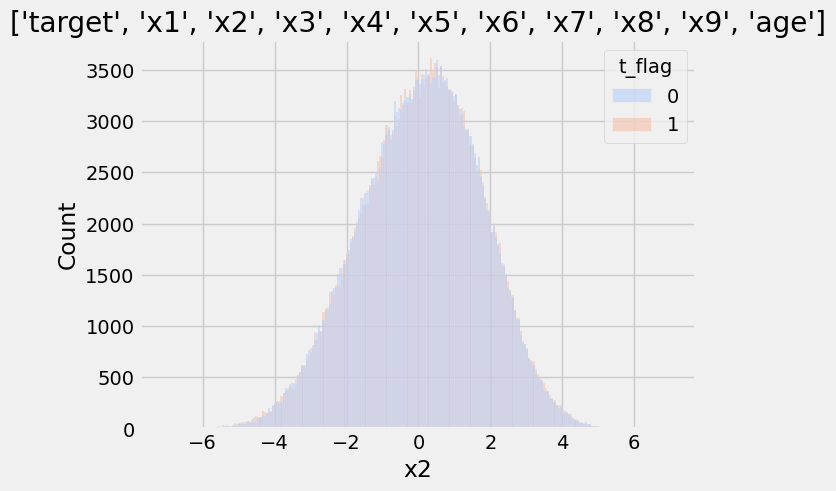

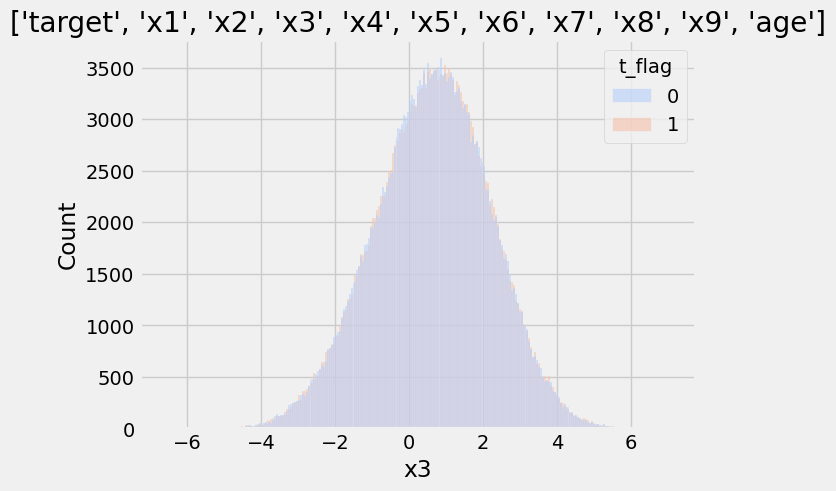

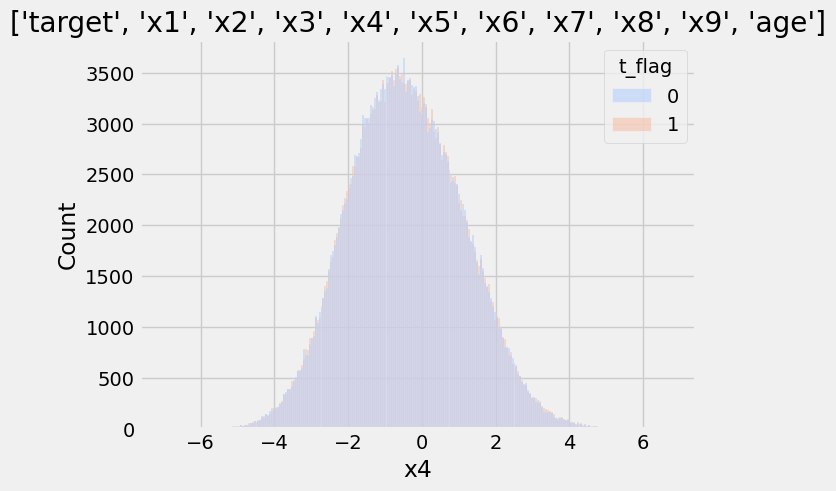

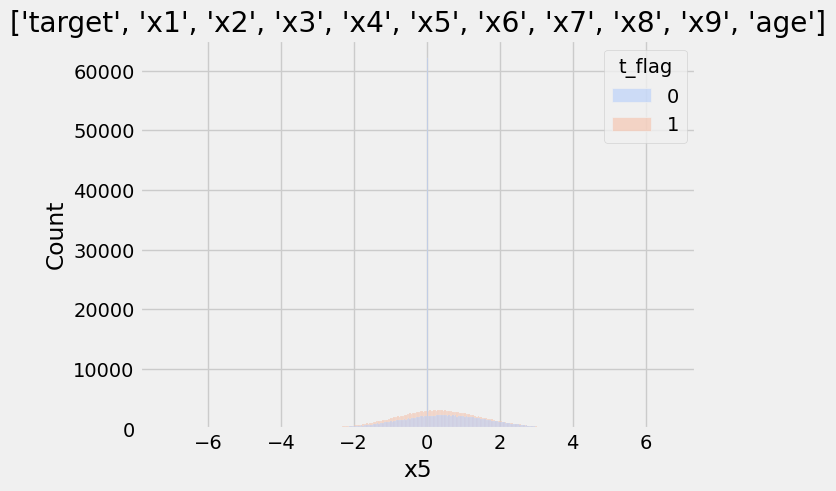

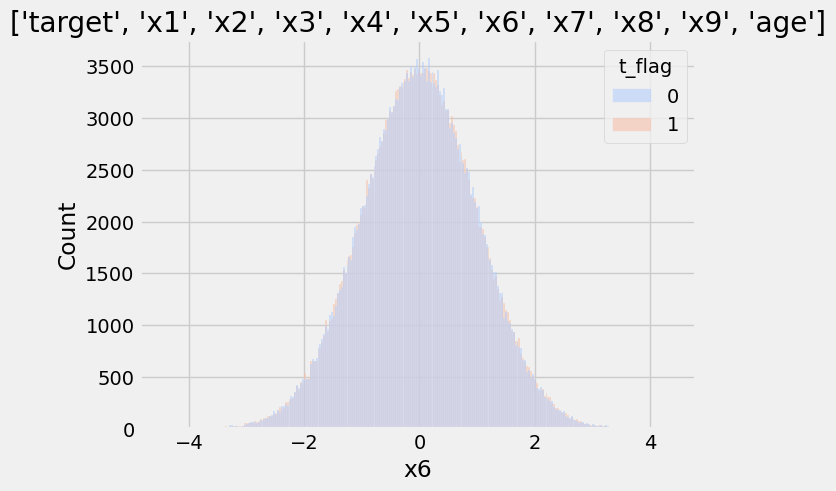

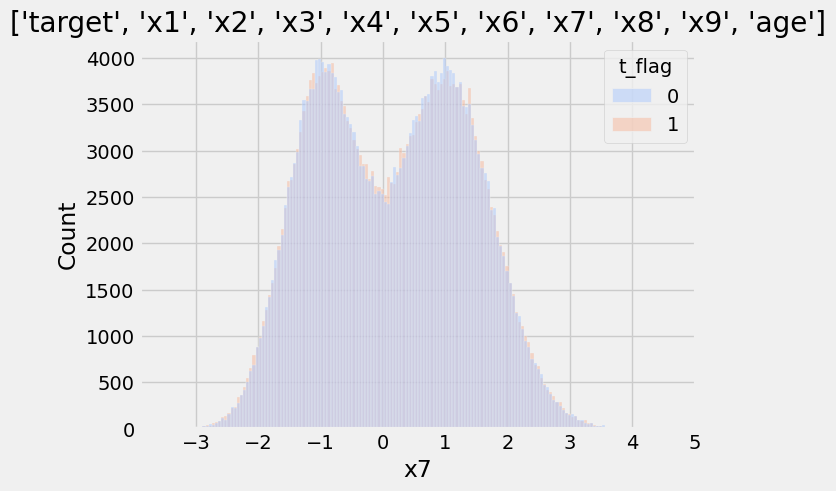

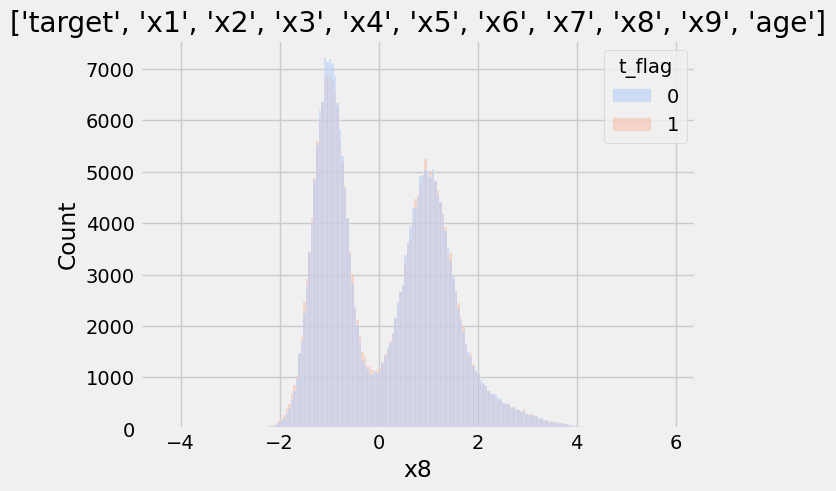

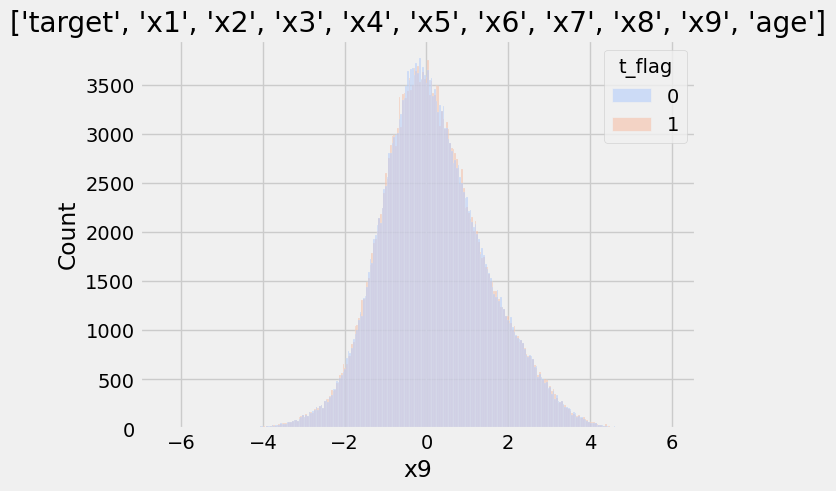

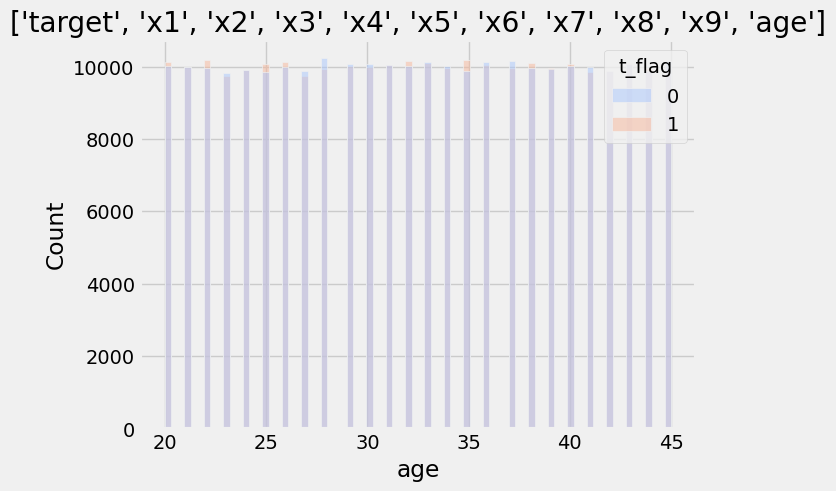

In [ ]:
plot_histograms(df, names, hue_column='t_flag', palette='coolwarm')

In [ ]:
# при помощи gpt сделали функцию для построения канальных переменных
def plot_channel_histograms(df, names, channel_column='channel', hue_column='t_flag', palette='coolwarm', figsize=(8, 5)):
    """
    Функция для построения гистограмм для каждого канала и каждого столбца из списка names.
    """
    channels = df[channel_column].dropna().unique()

    for channel in channels:
        df_channel = df[df[channel_column] == channel]

        for col in names:
            plt.figure(figsize=figsize)
            sns.histplot(data=df_channel, x=col, hue=hue_column, kde=True, palette=palette)
            plt.title(f'{col} | Channel: {channel}')
            plt.xlabel(col)
            plt.ylabel('Частота')
            plt.legend(title=hue_column)
            plt.show()

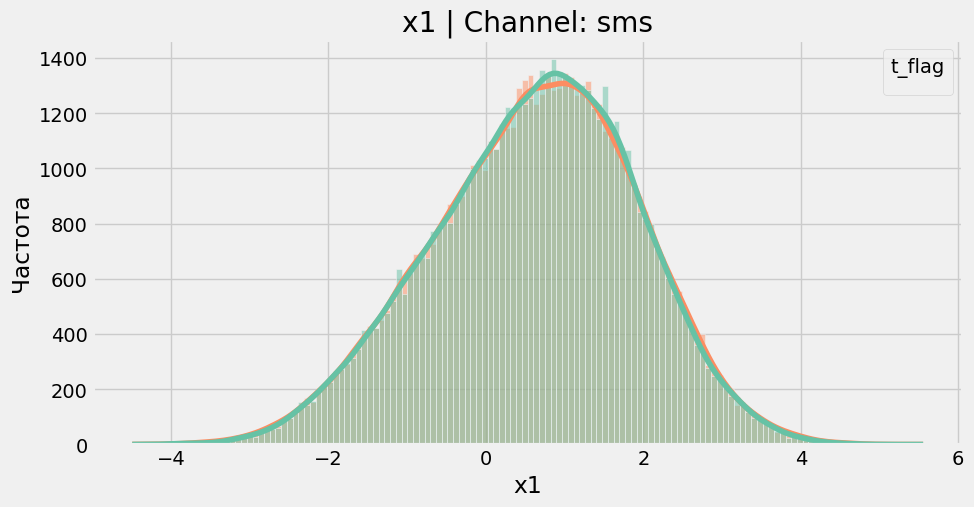

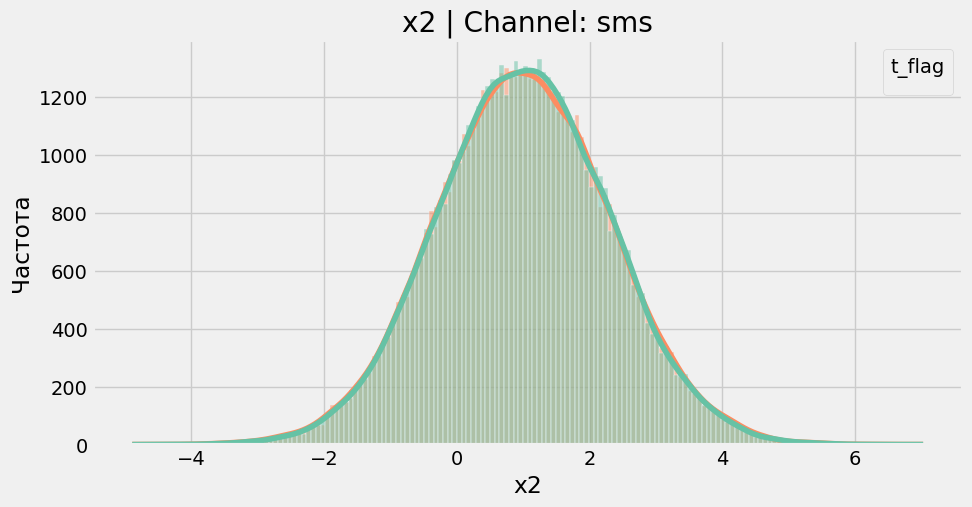

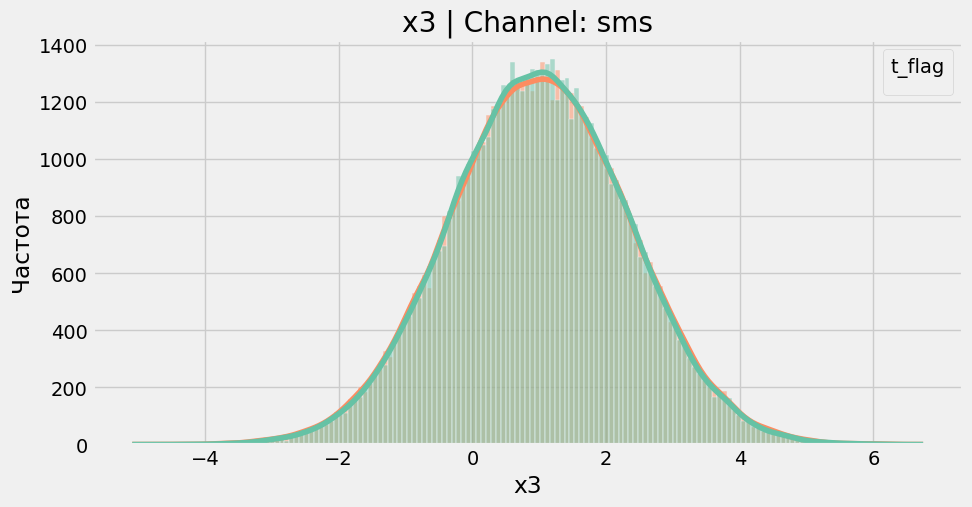

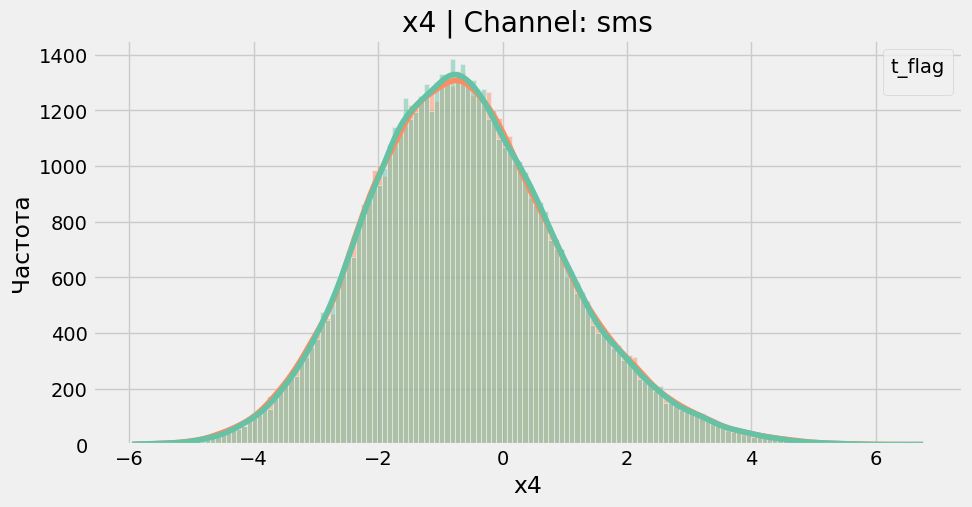

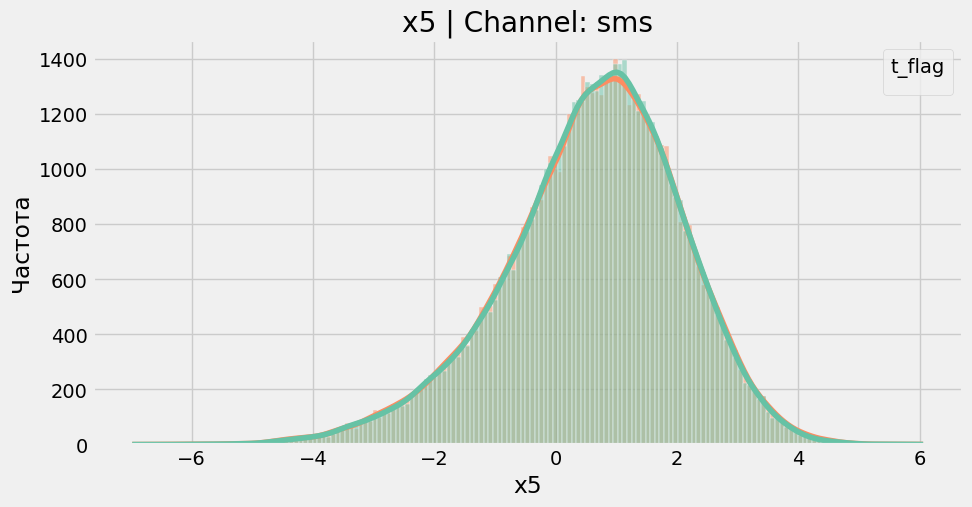

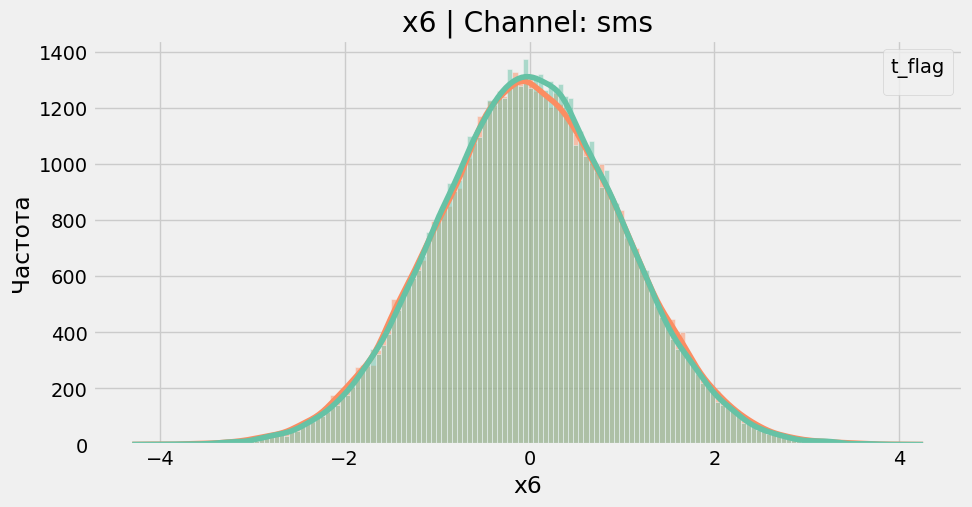

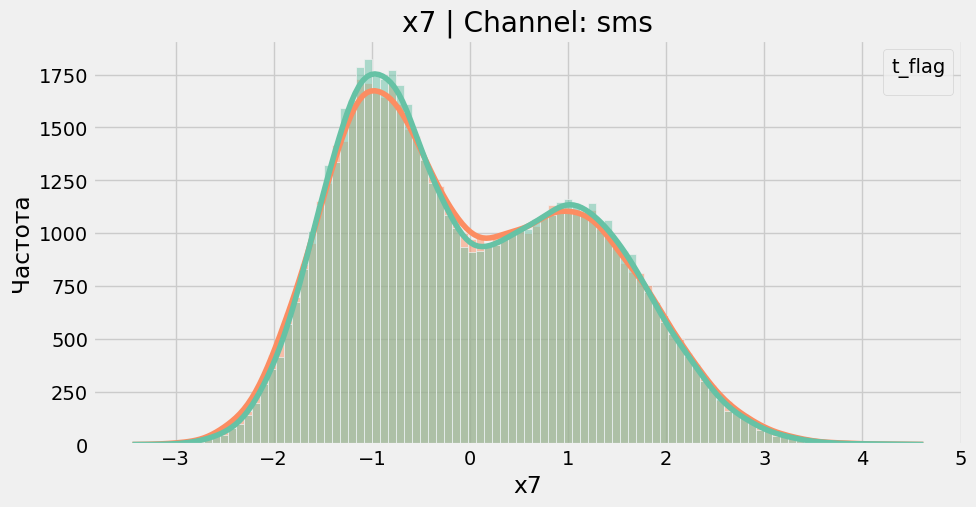

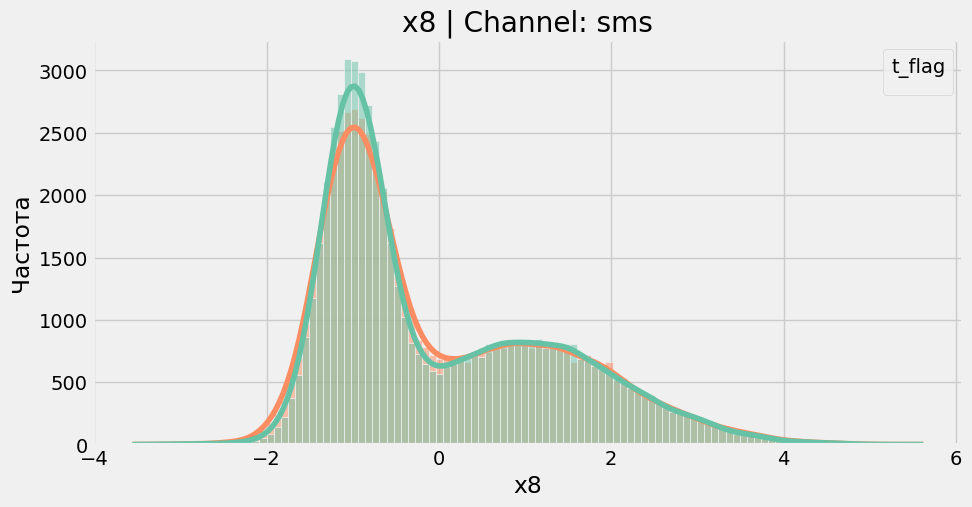

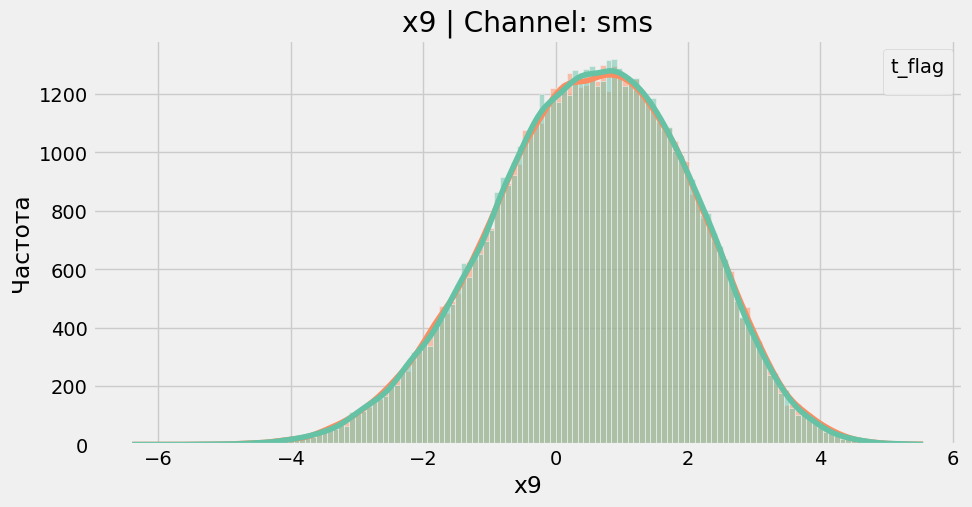

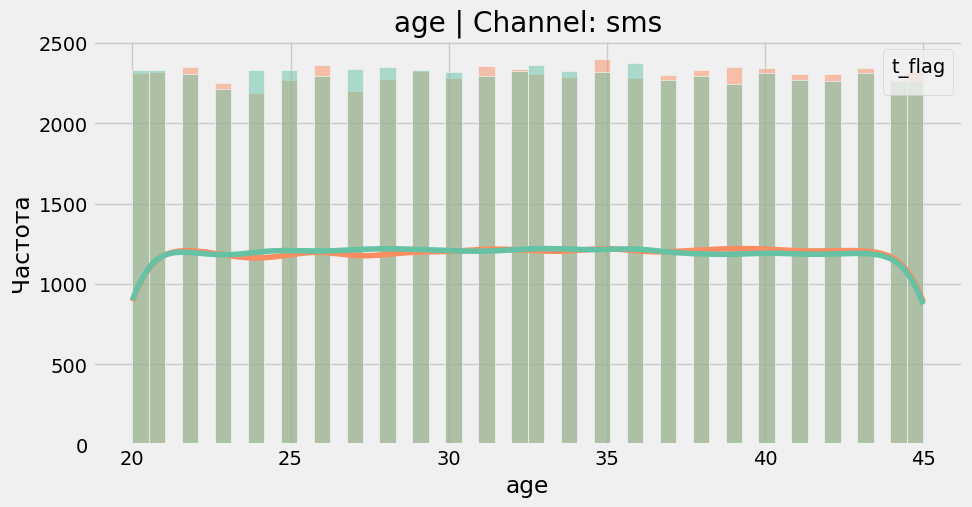

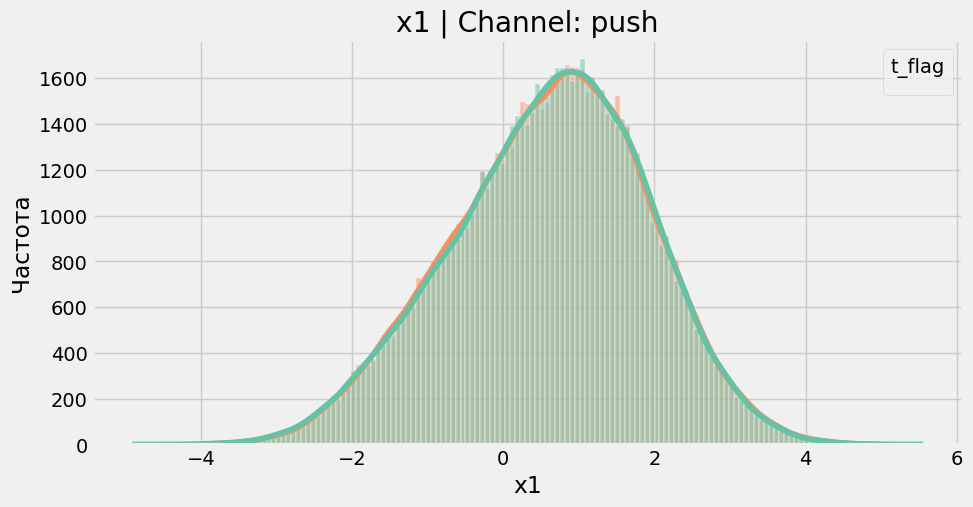

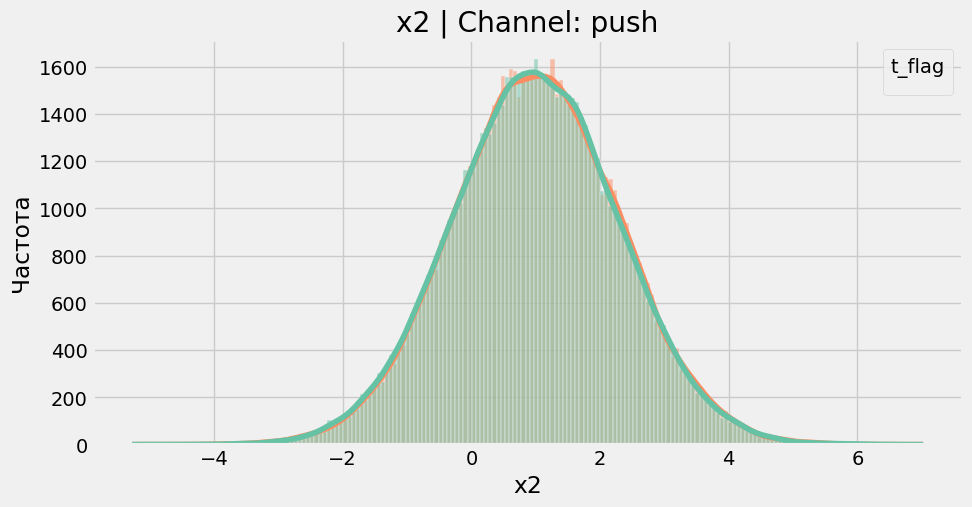

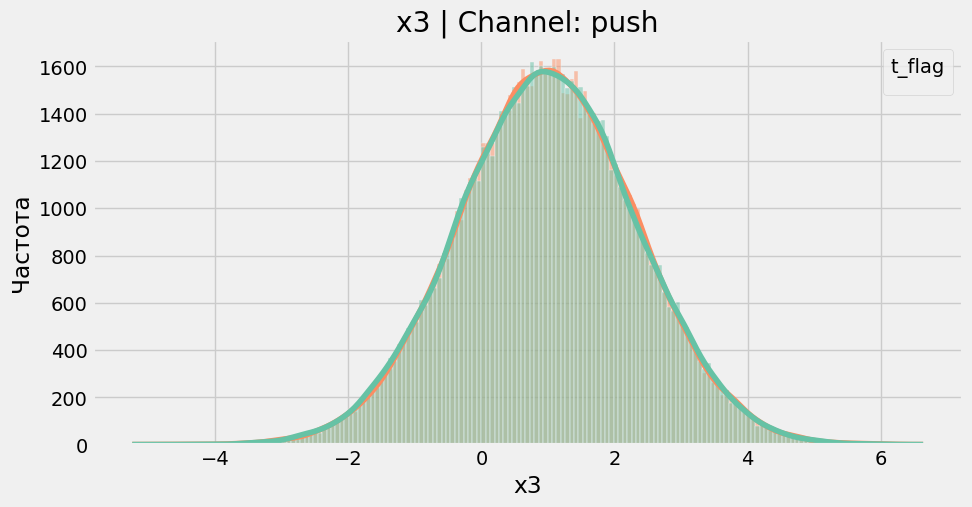

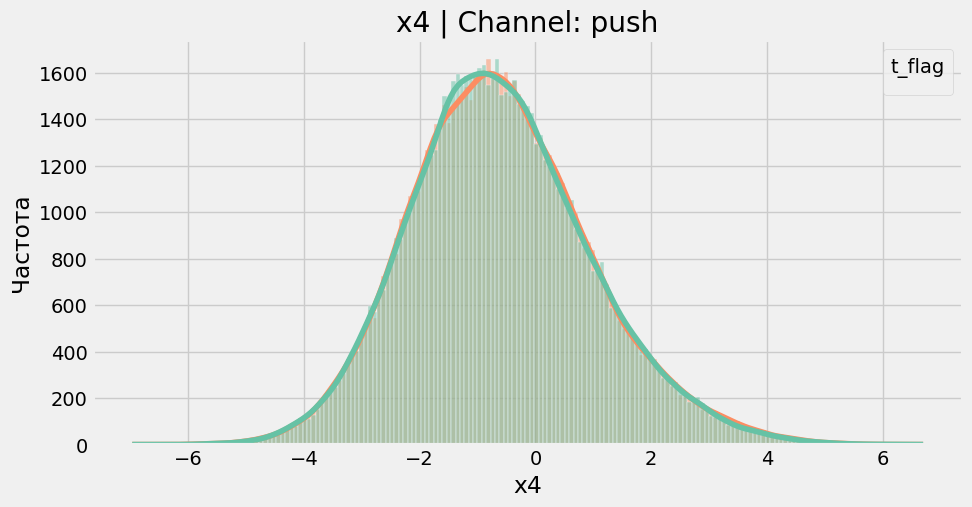

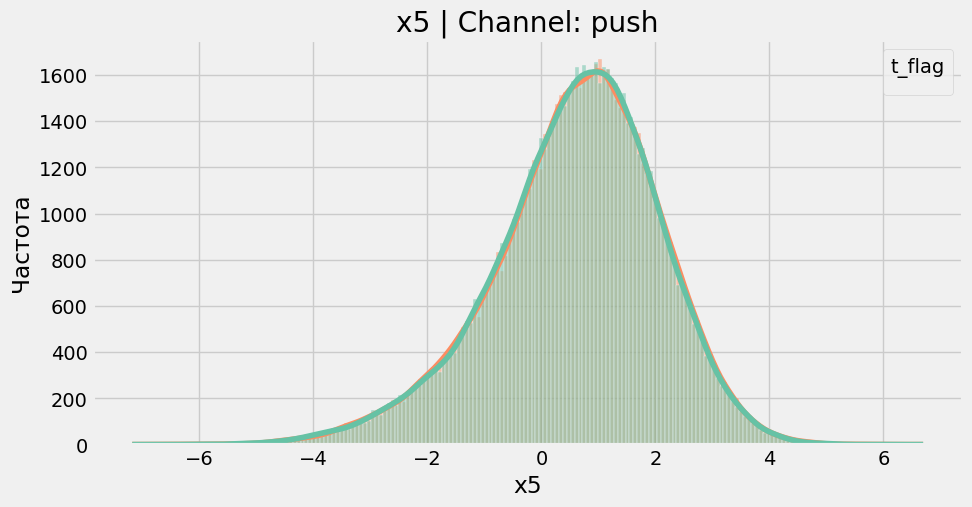

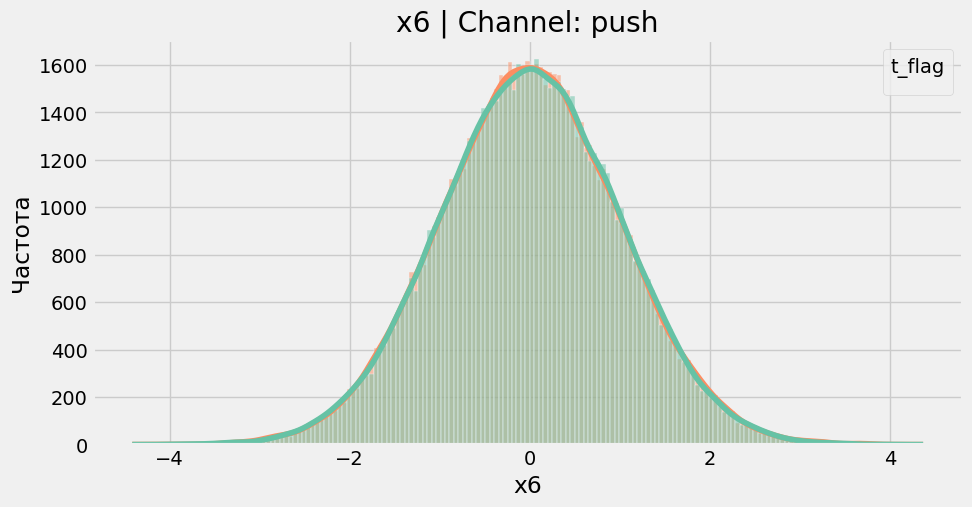

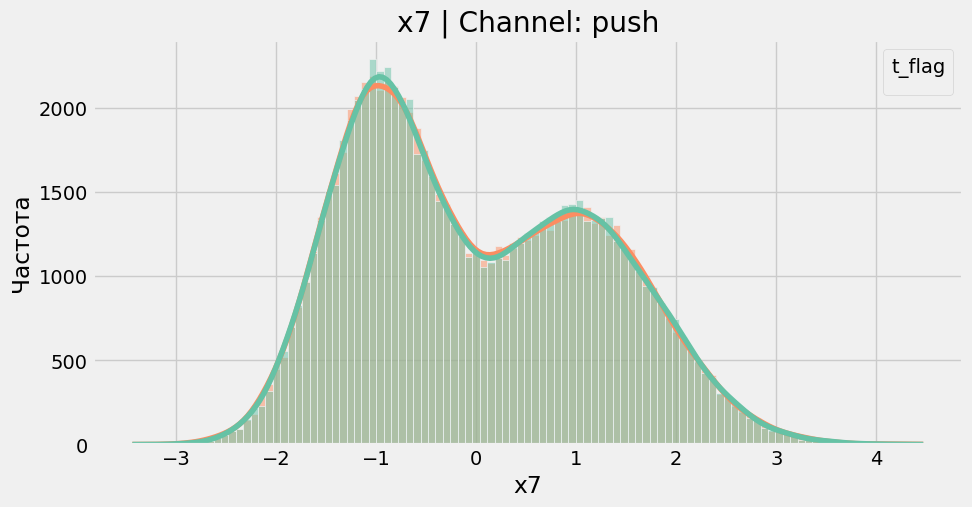

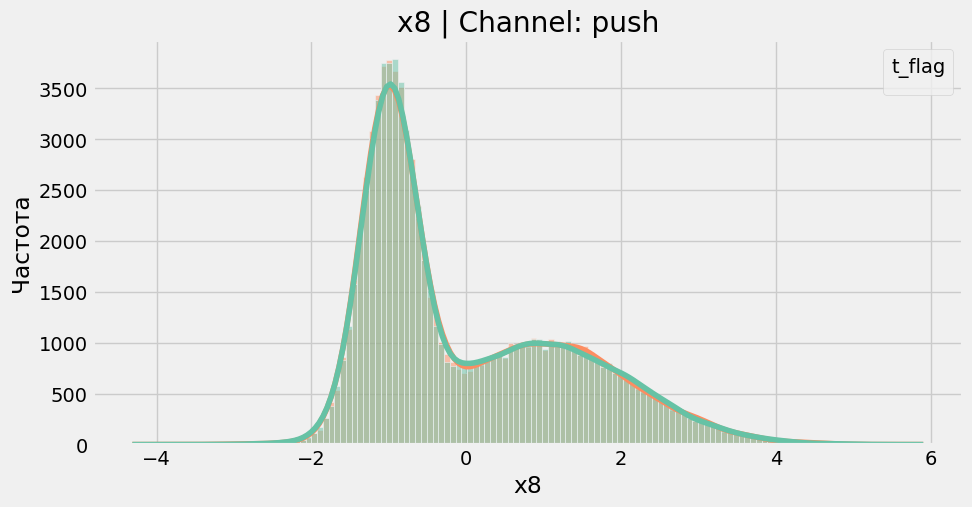

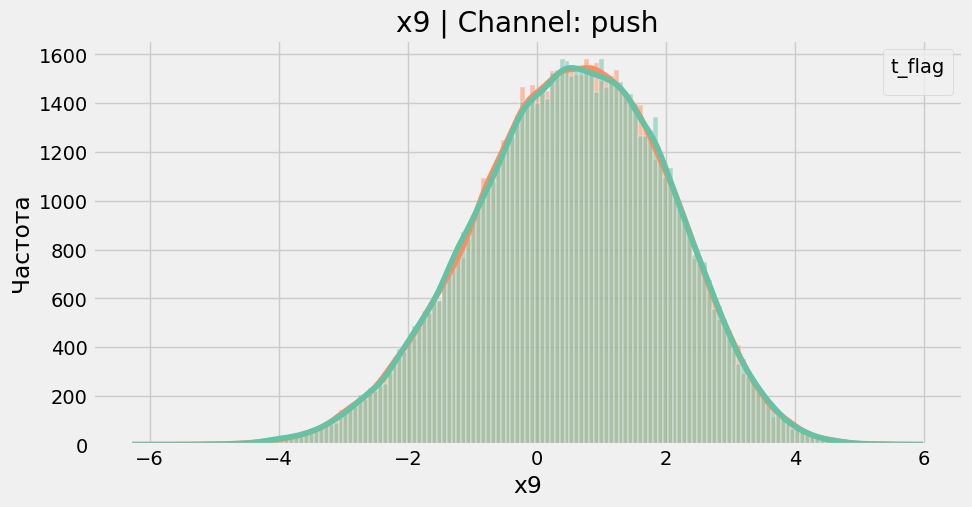

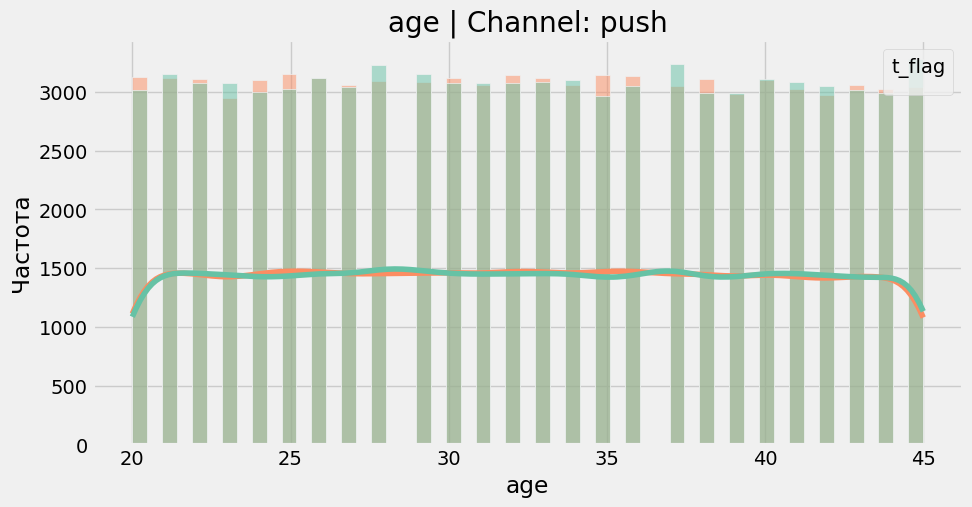

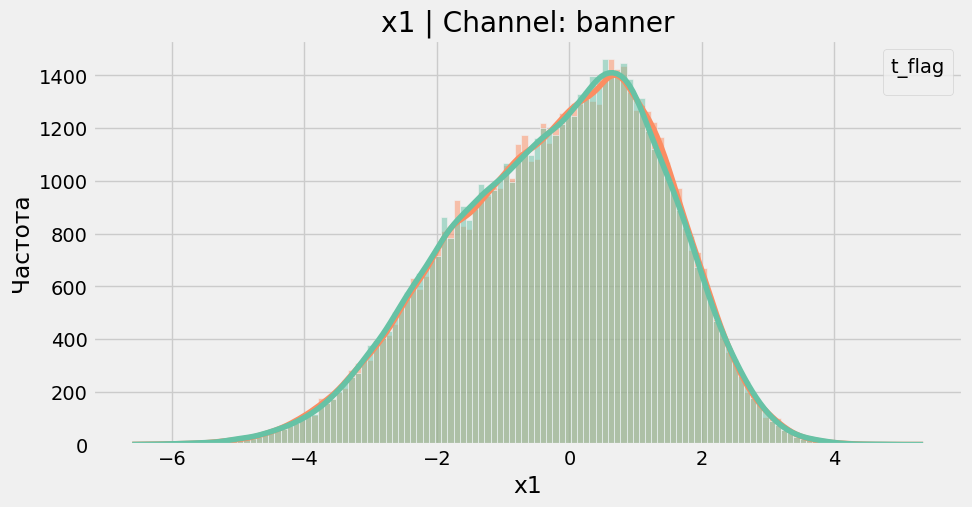

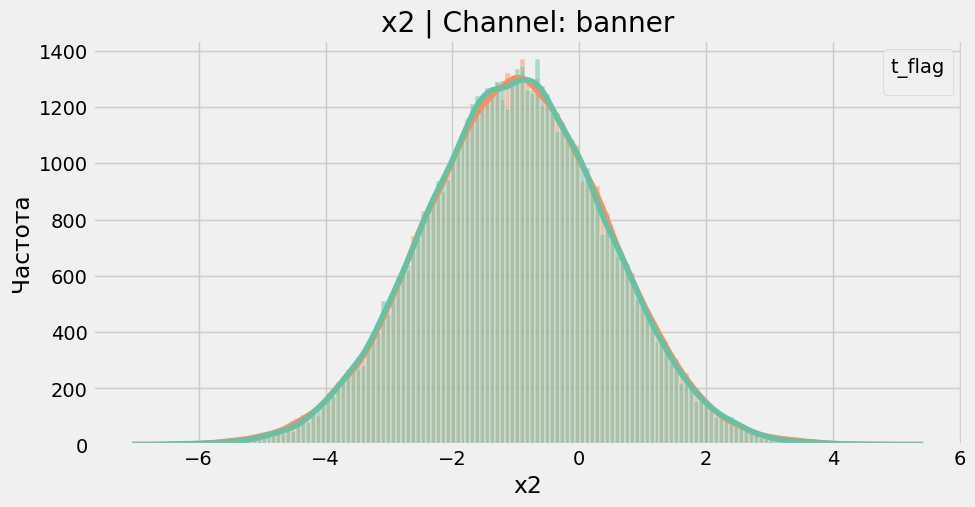

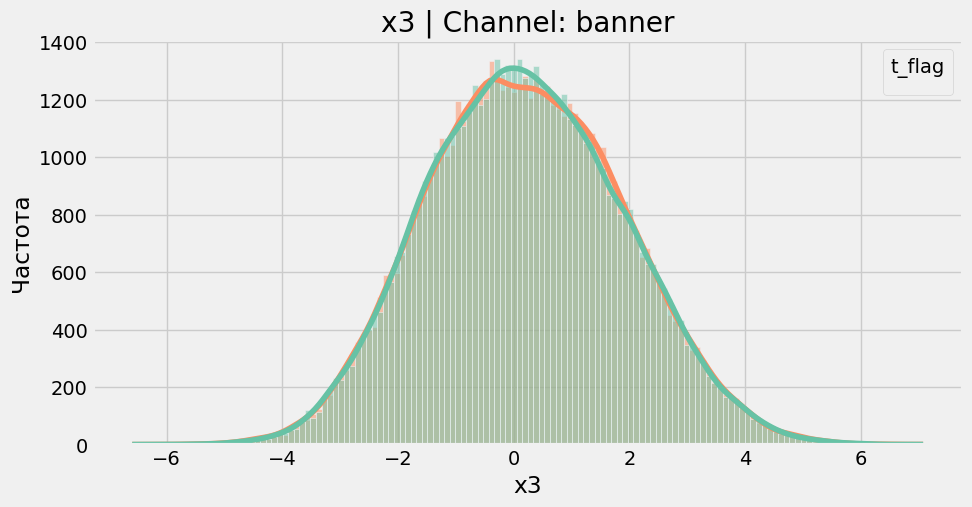

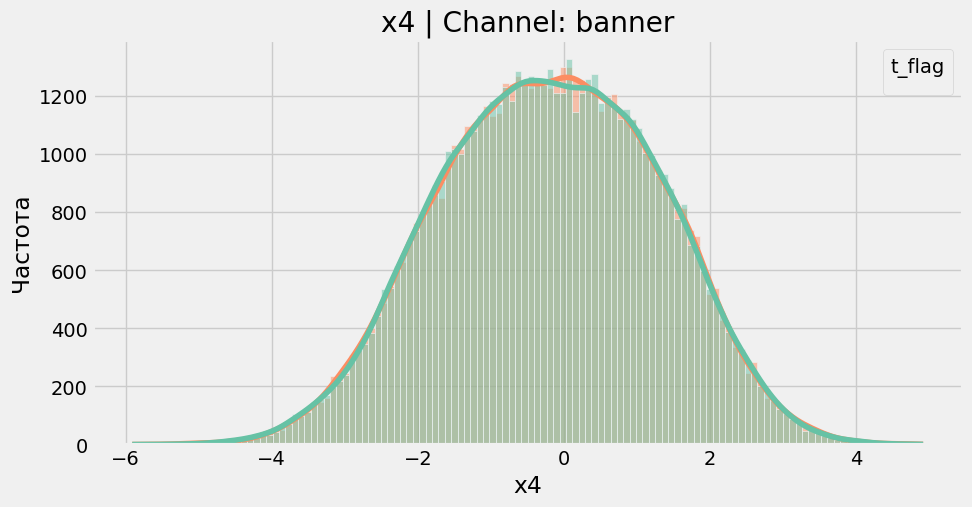

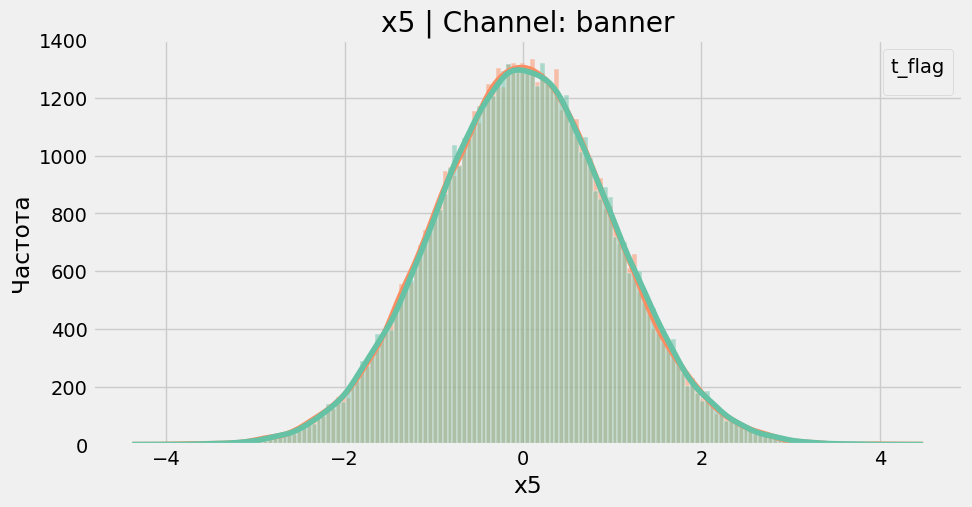

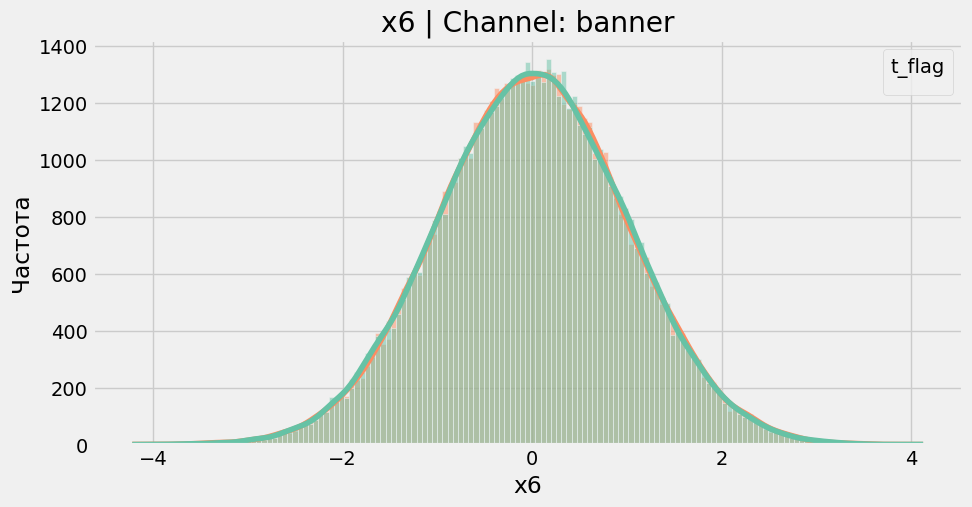

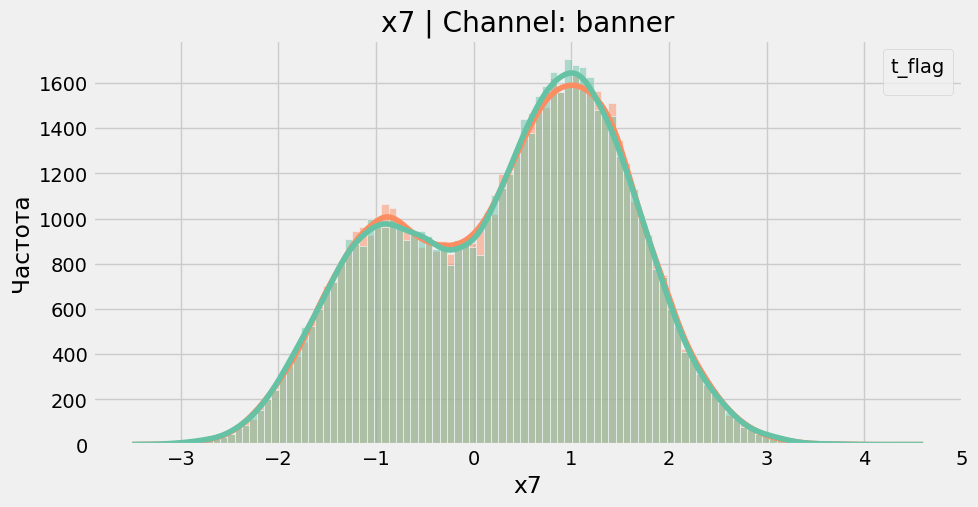

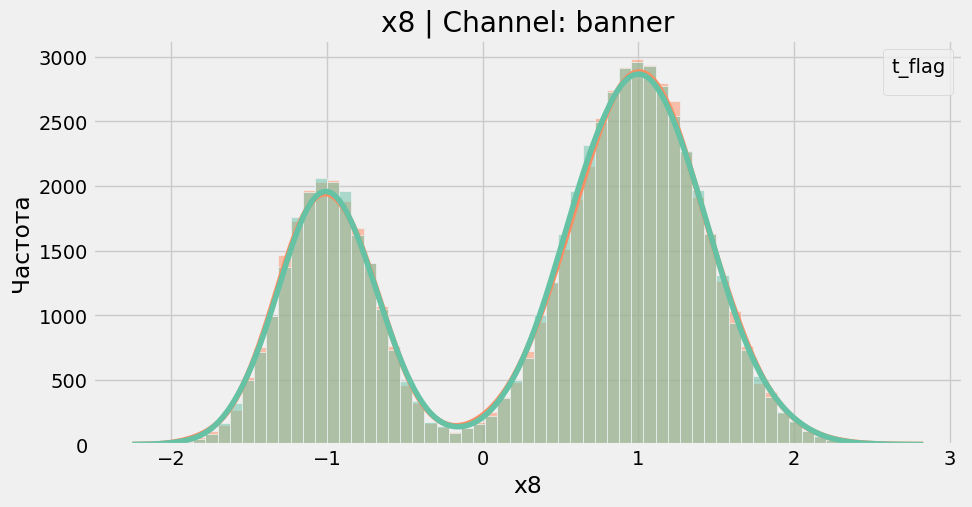

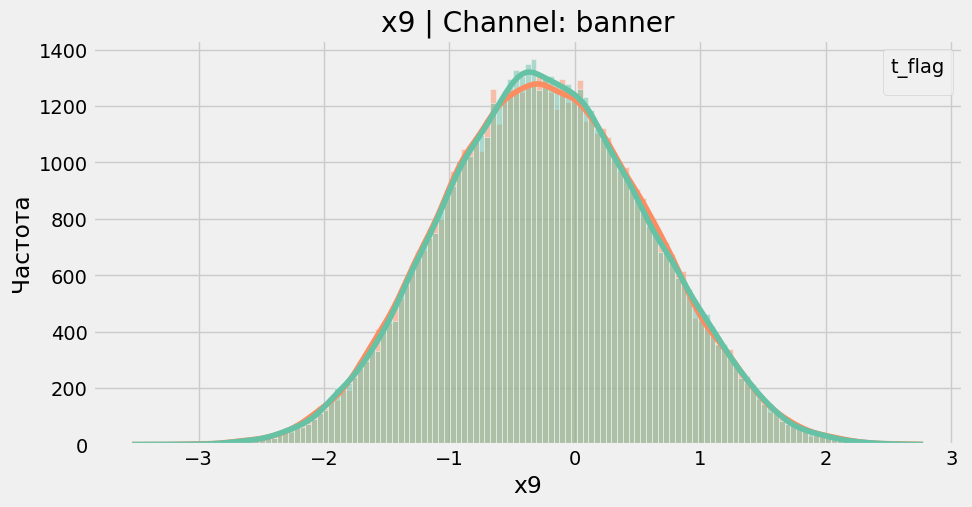

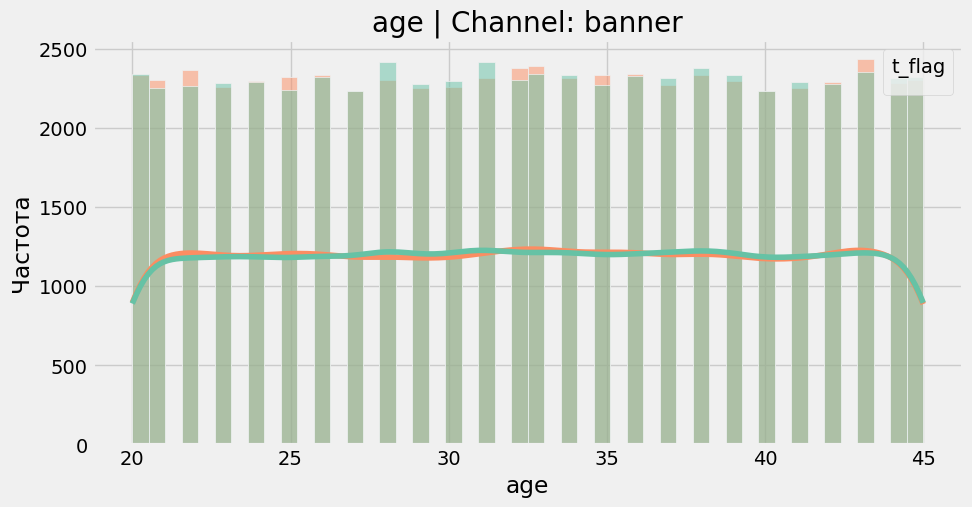

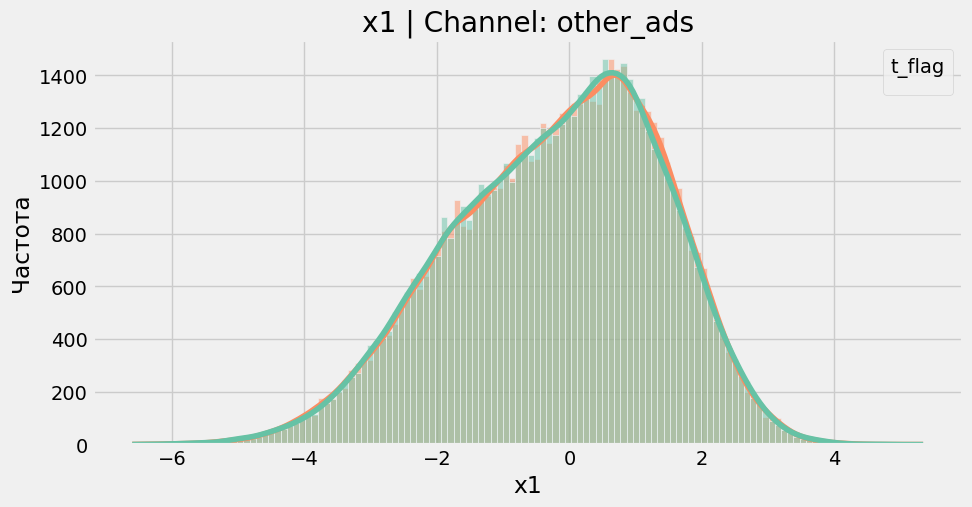

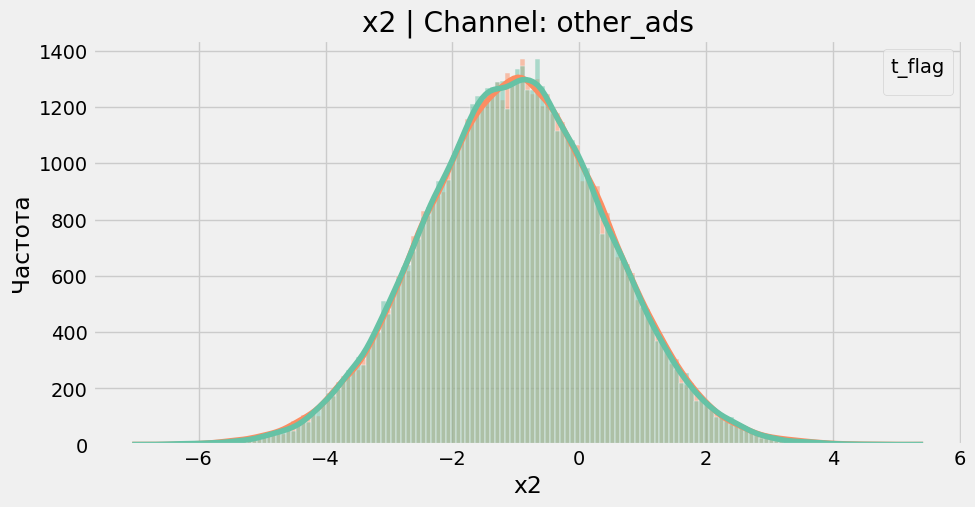

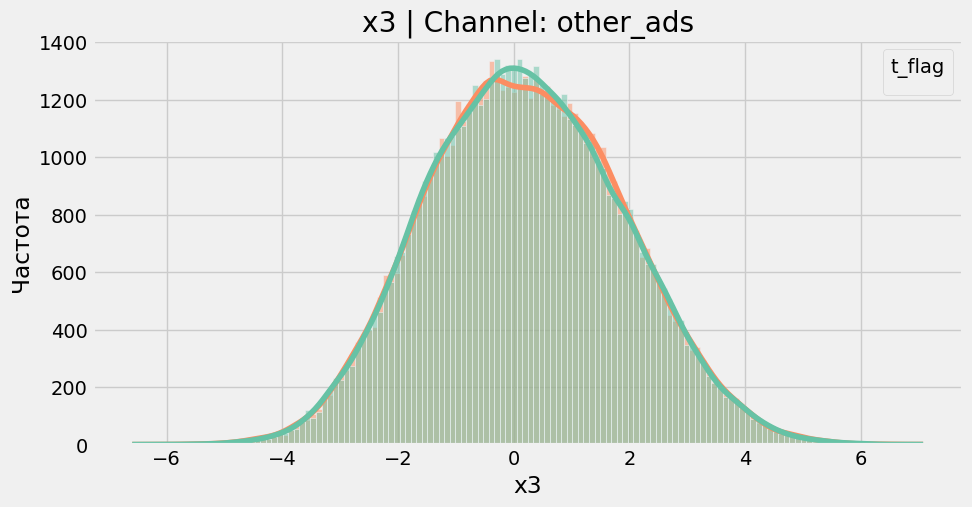

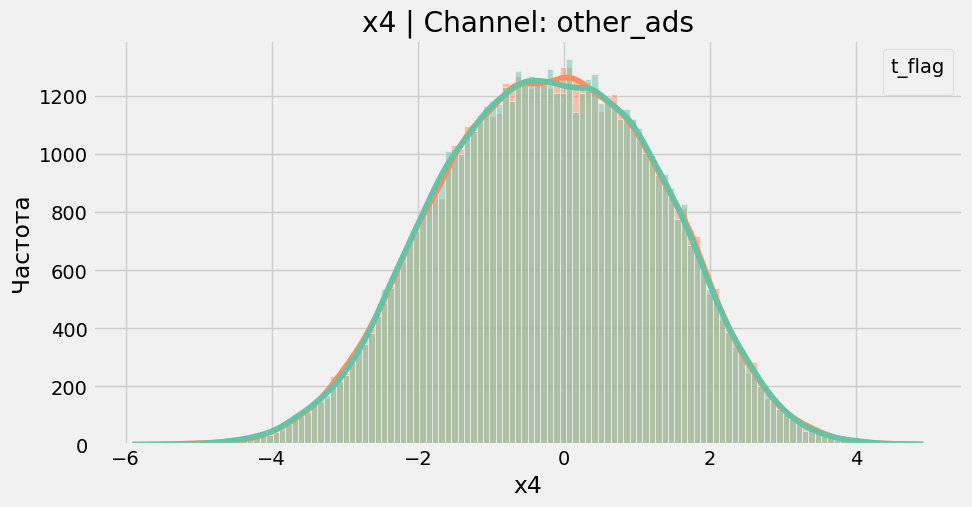

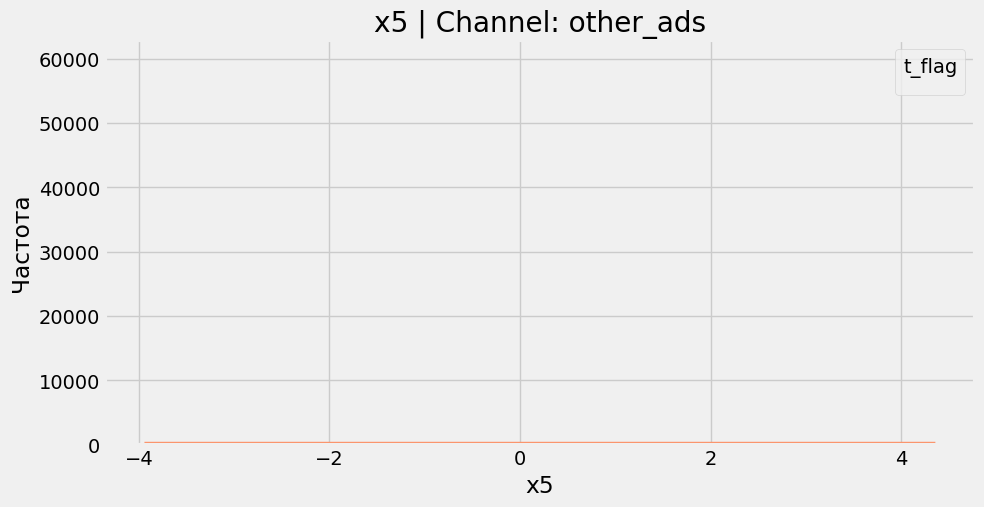

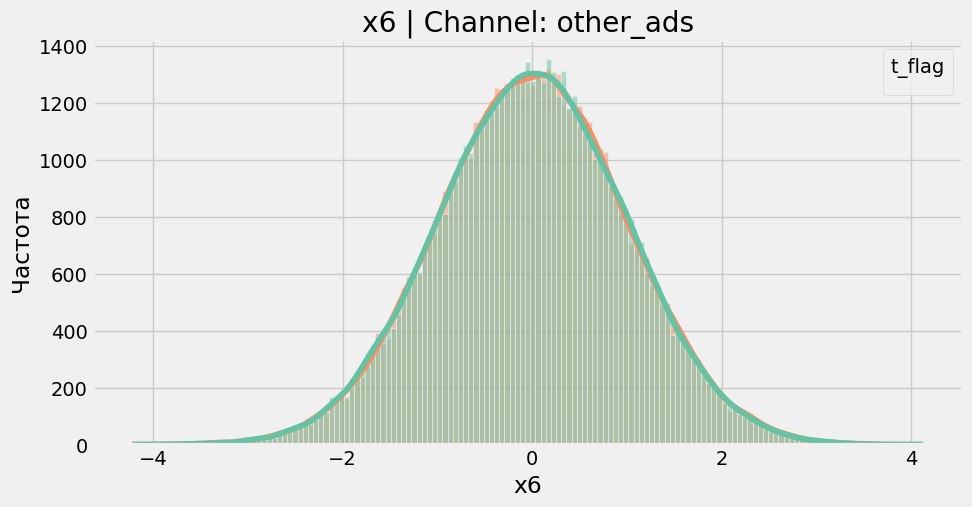

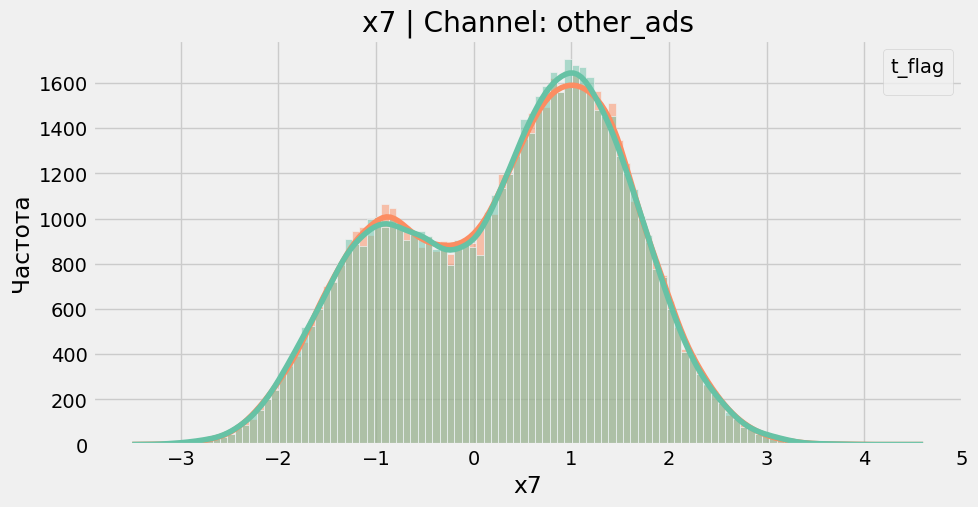

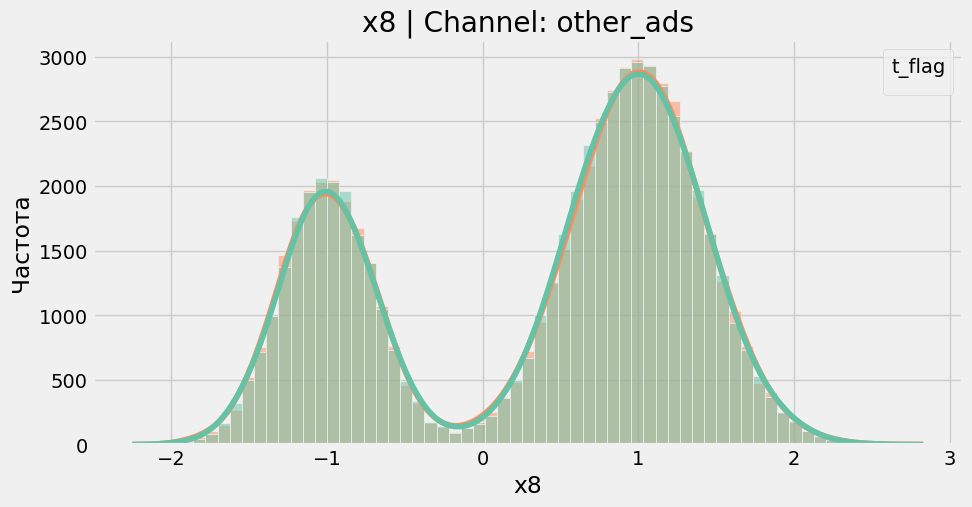

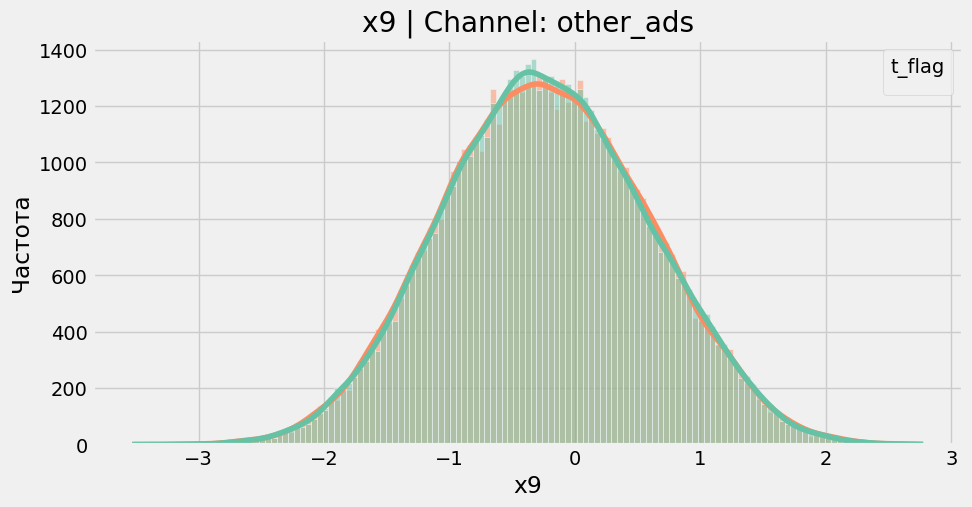

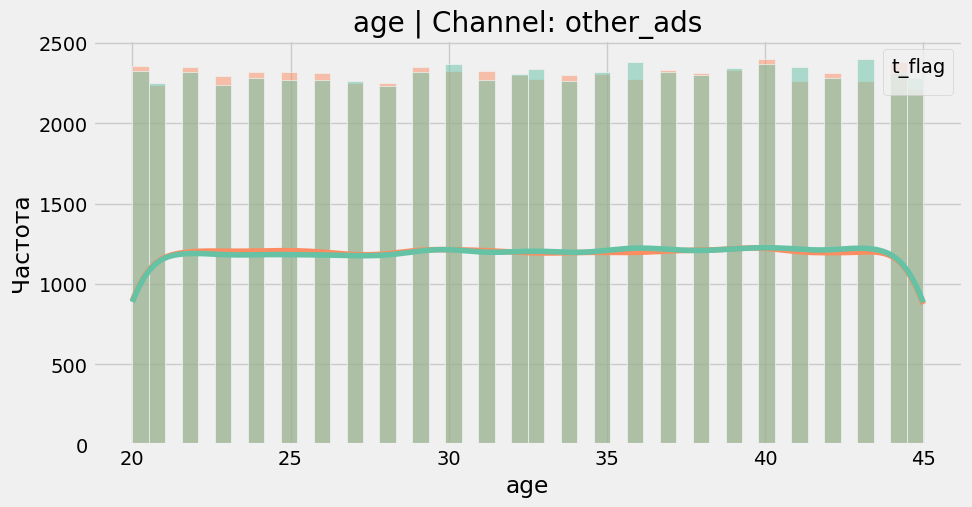

In [ ]:
plot_channel_histograms(df, names, channel_column='channel', hue_column='t_flag', palette='Set2', figsize=(10, 5))

Заметим, что по графикам наблдается разница статистическая, следовательно таргетные группы имеют правила формирования по различным бизнес идеям, возможно, это может соотвестововать разлыичными целями разных компаний.


In [ ]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''
    Calculate the PSI (population stability index) across all variables
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            if max - min == 0:
                input = np.zeros_like(input)
            else:
                input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [ ]:
# Просчитаем разности psi
df_droped = df.drop(columns = ['target'])
for col in names:
    psi = calculate_psi(expected = df_droped[df_droped['t_flag'] == 0][col],
                        actual = df_droped[df_droped['t_flag'] == 1][col])
    print(f'psi {col} = {psi:.6f}')
    print('-'*30)

psi x1 = 0.000067
------------------------------
psi x2 = 0.000248
------------------------------
psi x3 = 0.000047
------------------------------
psi x4 = 0.000077
------------------------------
psi x5 = 0.069875
------------------------------
psi x6 = 0.000080
------------------------------
psi x7 = 0.000236
------------------------------
psi x8 = 0.000368
------------------------------
psi x9 = 0.000068
------------------------------
psi age = 0.000058
------------------------------


как таковой разницы нет, самая максимальная разница заметна между x2 и x3, но это копеечный показатель

In [ ]:
# Просчитаем psi для channel
for i in df_droped['channel'].unique():
    print(f'psi для {i}')
    df_chan = df[df['channel'] == i]
    for col in names:
        psi = calculate_psi(expected = df_chan[df_chan['t_flag'] == 0][col],
                        actual  = df_chan[df_chan['t_flag'] == 1][col])
        print(f'psi {col} = {psi:.6f}')
        print('-'*30)

psi для sms
psi x1 = 0.000427
------------------------------
psi x2 = 0.000260
------------------------------
psi x3 = 0.000455
------------------------------
psi x4 = 0.000129
------------------------------
psi x5 = 0.000239
------------------------------
psi x6 = 0.001135
------------------------------
psi x7 = 0.001988
------------------------------
psi x8 = 0.009678
------------------------------
psi x9 = 0.000168
------------------------------
psi age = 0.000262
------------------------------
psi для push
psi x1 = 0.000277
------------------------------
psi x2 = 0.000216
------------------------------
psi x3 = 0.000191
------------------------------
psi x4 = 0.000264
------------------------------
psi x5 = 0.000214
------------------------------
psi x6 = 0.000214
------------------------------
psi x7 = 0.000165
------------------------------
psi x8 = 0.000323
------------------------------
psi x9 = 0.000053
------------------------------
psi age = 0.000234
------------------------

тут показатели индентичные прошлому циклу, но имеется явный выдилившийся показатель psi для other_ads x5 = 9.209419, похоже на выброс.


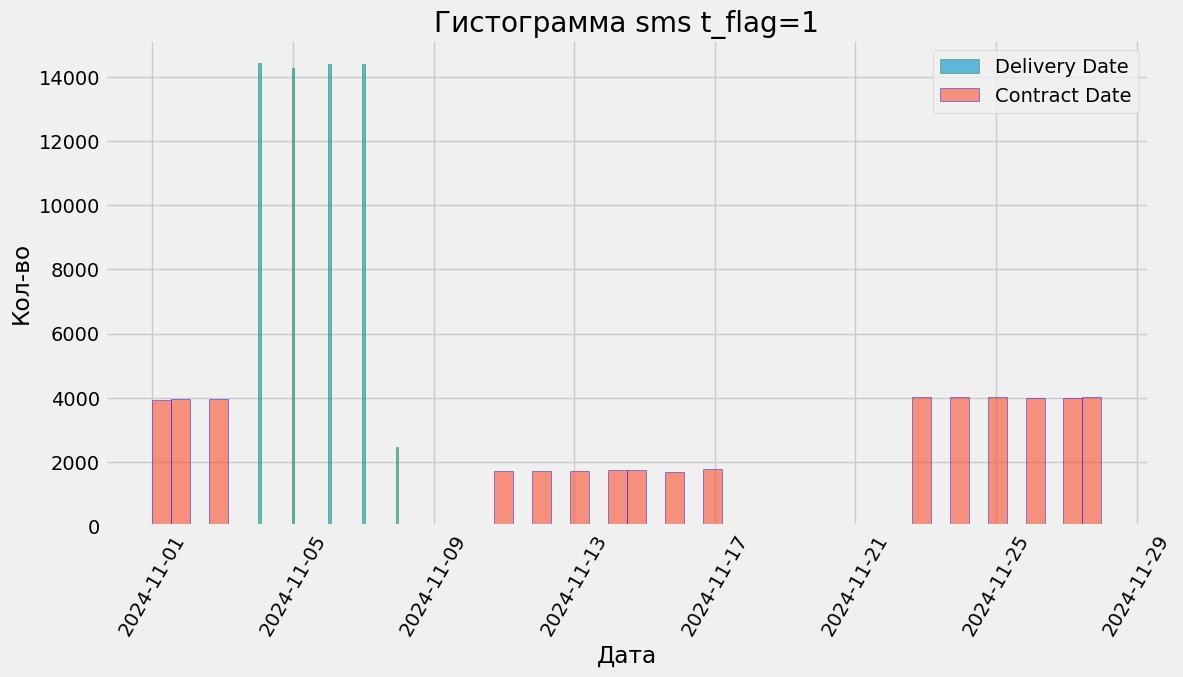

In [ ]:
# визуализируем данные для таргетной переменной
plt.figure(figsize=(12, 6))
sms_channel = df[(df['channel'] == 'sms')&(df['t_flag']==1)]

plt.hist(sms_channel['delivery_date'].dropna(), bins=50, alpha=0.6, label='Delivery Date', edgecolor='green')
plt.hist(sms_channel['contract_date'].dropna(), bins=50, alpha=0.6, label='Contract Date', edgecolor='blue')

plt.title('Гистограмма sms t_flag=1')
plt.xlabel('Дата')
plt.ylabel('Кол-во')
plt.xticks(rotation=60)
plt.legend()
plt.show()

по графику похоже, что некоторые юзеры совершали покупки до смс-рассылок.

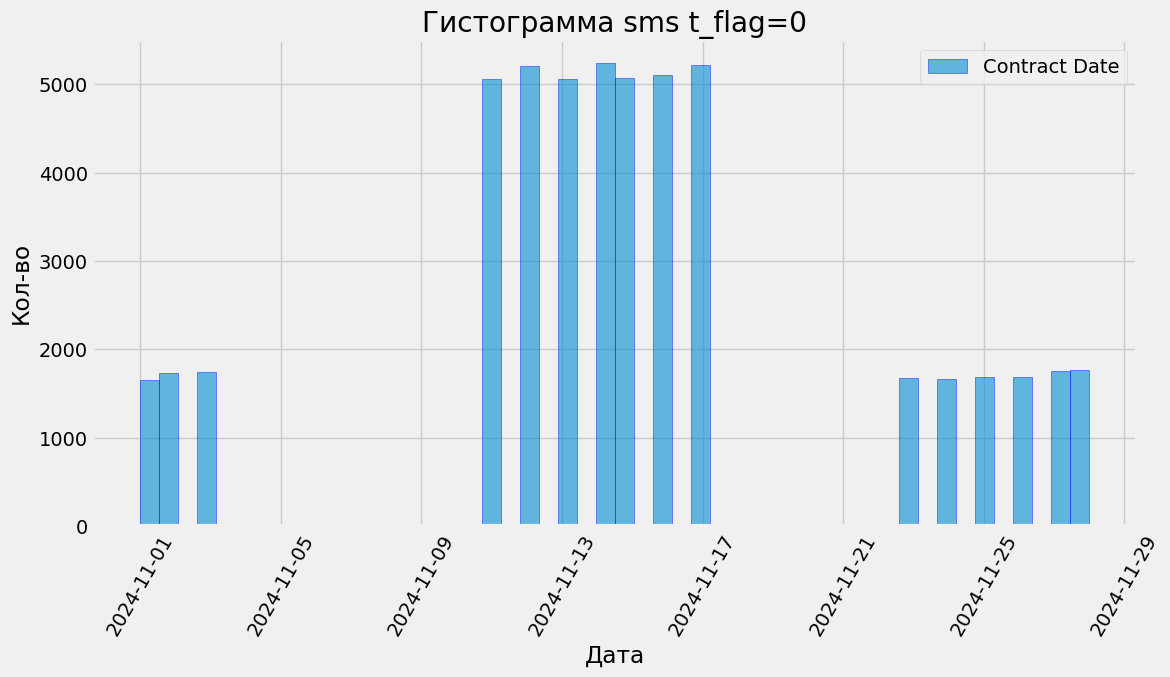

In [ ]:
# визуализируем данные для контрольной грппы
plt.figure(figsize=(12, 6))
sms_chan = df[(df['channel'] == 'sms')&(df['t_flag']==0)]

plt.hist(sms_chan['contract_date'].dropna(), bins=50, alpha=0.6, label='Contract Date', edgecolor='blue')

plt.title('Гистограмма sms t_flag=0')
plt.xlabel('Дата')
plt.ylabel('Кол-во')
plt.xticks(rotation=60)
plt.legend()

plt.show()

больший наплыв покупок совершались с 10 по 17 число, возможно в этом можно предположить, что этот график может быть сезонным, так как середина ноября, может быть люди заранее начали готовится к новому году и закупают какие-либо подарки

psi показал, что группы контрольной и целепой переменных очень схожи, но помни об аномалии в лице  psi для other_ads x5 = 9.209419
также можно обратить внимание на то, что на визуализациях показано , что покупок у контрольной группы значительно больше, чем в целевой, возможно она сломана - непонятно

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [ ]:
# сделаем датасет для построения моделей
names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']
col_for_model = names + ["t_flag"] + ["target"] + ['channel']
df_final = df[col_for_model]
df_final.head()

x1        x2        x3        x4        x5        x6        x7  \
0  0.822461  1.233201 -1.000185  2.585873 -0.584520 -0.268274 -0.727814   
1 -1.224545  1.688111  0.150933  3.230149 -0.189105  0.551481 -1.229590   
2 -0.916137  1.368764  1.841319 -1.529691 -0.608003 -1.116932  1.178124   
3 -1.620401  2.449667  1.131850  1.021660 -1.212641  0.958422  1.039261   
4  2.281651 -0.354332  1.288191 -2.754188  0.202581  0.831745 -0.002779   

         x8        x9  age  t_flag  target channel  
0  1.606372  1.814158   42       1       1     sms  
1  1.159411 -0.085720   39       1       1    push  
2 -0.884607 -1.726070   43       1       0    push  
3 -0.964264 -2.225545   39       0       1     sms  
4 -1.463527  1.976755   39       0       0    push

In [ ]:
# уберем некорректные компании
df_push = df_final[df_final["channel"] == "push"].drop('channel', axis=1)
df_banner = df_final[df_final["channel"] == "banner"].drop('channel', axis=1)
df_other_ads = df_final[df_final["channel"] == "other_ads"].drop('channel', axis=1)

In [ ]:
df_push.head()

x1        x2        x3        x4        x5        x6        x7  \
1  -1.224545  1.688111  0.150933  3.230149 -0.189105  0.551481 -1.229590   
2  -0.916137  1.368764  1.841319 -1.529691 -0.608003 -1.116932  1.178124   
4   2.281651 -0.354332  1.288191 -2.754188  0.202581  0.831745 -0.002779   
12 -0.773911  1.877601  0.582218  1.699295 -0.667554 -0.018505  0.337289   
17  0.457746  1.407223  0.803963 -2.002316  0.928291 -1.389908 -1.823737   

          x8        x9  age  t_flag  target  
1   1.159411 -0.085720   39       1       1  
2  -0.884607 -1.726070   43       1       0  
4  -1.463527  1.976755   39       0       0  
12 -1.101638 -0.936927   33       0       1  
17 -0.512010  1.840791   27       0       0

In [ ]:
df_banner.head()

x1        x2        x3        x4        x5        x6        x7  \
5  -1.821441 -0.847392  1.020568 -1.611153  0.933913  0.236984  0.933495   
7   1.768029 -1.560275  0.533826 -1.815031 -0.456184  0.274609  0.077484   
15  1.835344  1.073112 -0.629534  0.885258 -0.046115  1.253187 -1.129575   
18 -2.560545 -1.059789  1.364528  0.162776  0.918376 -0.674086  1.523135   
25 -2.473590  0.538802  2.107212 -2.082812 -1.205763 -0.820763  0.955939   

          x8        x9  age  t_flag  target  
5   0.795683 -0.812175   30       0       0  
7   0.452296 -0.224605   21       1       0  
15 -0.397609  0.770880   36       0       1  
18  1.669412 -1.219946   20       1       0  
25  0.626842 -1.203440   31       0       0

In [ ]:
df_other_ads.head()

x1        x2        x3        x4        x5        x6        x7  \
6  -1.952636 -0.479671  1.067760 -1.521329 -0.687298  0.327018  1.052708   
9   2.365226 -1.303713  0.133301  2.098386 -0.000000  0.285846  0.545567   
10 -1.691378 -2.037854  0.720855  0.078692  0.000000  0.200561 -0.473317   
14  0.719305 -3.875339 -2.520893  1.791964  0.000000 -0.349731  0.770023   
16  2.463179 -1.582447 -1.924806  2.421979  0.304232 -0.923602  1.005434   

          x8        x9  age  t_flag  target  
6   1.244605 -0.886796   25       1       0  
9   0.293677 -0.312559   36       0       1  
10 -1.199639 -0.021610   29       0       0  
14  0.550603  0.507014   33       0       1  
16  0.763082  0.183646   27       1       1

In [ ]:
# также избавимся от аномалии
df_other_ads = df_other_ads.drop(columns = ['x5'])
df_other_ads.head()

x1        x2        x3        x4        x6        x7        x8  \
6  -1.952636 -0.479671  1.067760 -1.521329  0.327018  1.052708  1.244605   
9   2.365226 -1.303713  0.133301  2.098386  0.285846  0.545567  0.293677   
10 -1.691378 -2.037854  0.720855  0.078692  0.200561 -0.473317 -1.199639   
14  0.719305 -3.875339 -2.520893  1.791964 -0.349731  0.770023  0.550603   
16  2.463179 -1.582447 -1.924806  2.421979 -0.923602  1.005434  0.763082   

          x9  age  t_flag  target  
6  -0.886796   25       1       0  
9  -0.312559   36       0       1  
10 -0.021610   29       0       0  
14  0.507014   33       0       1  
16  0.183646   27       1       1

In [ ]:
# деление на train and test
random_state= 42

X_train_push, X_test_push, y_train_push, y_test_push = train_test_split(df_push.drop(columns = 'target'), df_push.target, test_size=0.25, random_state=random_state, stratify=df_push.target)

In [ ]:
X_train_banner, X_test_banner, y_train_banner, y_test_banner = train_test_split(df_banner.drop(columns = 'target'), df_banner.target, test_size=0.25, random_state=random_state, stratify=df_banner.target)

In [ ]:
X_train_other_ads, X_test_other_ads, y_train_other_ads, y_test_other_ads = train_test_split(df_other_ads.drop(columns = 'target'), df_other_ads.target, test_size=0.25, random_state=random_state, stratify=df_other_ads.target)

In [ ]:
# масштабируем данные
scaler = MinMaxScaler()
X_train_push = pd.DataFrame(scaler.fit_transform(X_train_push), columns=X_train_push.columns, index=X_train_push.index)
X_test_push = pd.DataFrame(scaler.transform(X_test_push), columns=X_test_push.columns, index=X_test_push.index)


In [ ]:
X_train_banner = pd.DataFrame(scaler.fit_transform(X_train_banner), columns=X_train_banner.columns, index=X_train_banner.index)
X_test_banner = pd.DataFrame(scaler.transform(X_test_banner), columns=X_test_banner.columns, index=X_test_banner.index)

In [ ]:
X_train_other_ads = pd.DataFrame(scaler.fit_transform(X_train_other_ads), columns=X_train_other_ads.columns, index=X_train_other_ads.index)
X_test_other_ads = pd.DataFrame(scaler.transform(X_test_other_ads), columns=X_test_other_ads.columns, index=X_test_other_ads.index)


In [ ]:
def calculate_simple_solomodel_uplift(X_train, X_test, y_train, random_state=42):
    """
    Обучает модель логрег и считает uplift.
    """
    model = LogisticRegression(random_state=random_state)
    model.fit(X_train, y_train)
    X_test_0 = X_test.copy()
    X_test_0['t_flag'] = 0
    y_pred_0 = model.predict_proba(X_test_0)[:, 1]

    X_test_1 = X_test.copy()
    X_test_1['t_flag'] = 1
    y_pred_1 = model.predict_proba(X_test_1)[:, 1]

    uplift = y_pred_1 - y_pred_0
    return uplift

In [ ]:
#!pip install scikit-learn==1.3.2
#!pip install scikit-uplift==0.5.1


In [ ]:
from sklift.viz import plot_qini_curve, plot_uplift_curve
from sklift.metrics import qini_auc_score

In [ ]:
# считаем для push
uplift_simple_solo_push = calculate_simple_solomodel_uplift(X_train_push, X_test_push, y_train_push)

print(qini_auc_score(y_true=y_test_push, uplift=uplift_simple_solo_push.flatten(), treatment=X_test_push['t_flag']))


0.21349192403923176


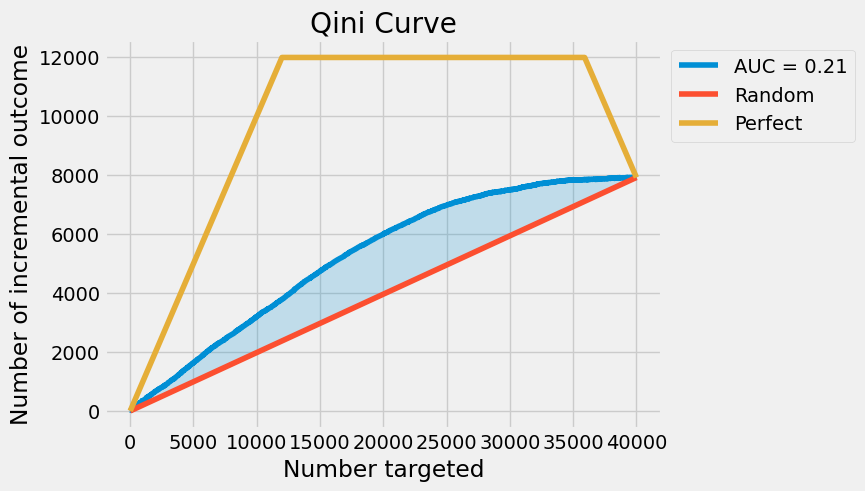

In [ ]:
# построим график push channel
plot_qini_curve(y_true=y_test_push, uplift=uplift_simple_solo_push.flatten(), treatment=X_test_push['t_flag'])
plt.title("Qini Curve")
plt.show()

In [ ]:
def plot_uplift_distribution(uplift_values, bins=30, kde=True):
    """
    Функция для построения распределения значений Uplift.
    """
    if isinstance(uplift_values, (pd.Series, pd.DataFrame)):
        uplift_values = uplift_values.values.flatten()
    elif isinstance(uplift_values, np.ndarray):
        uplift_values = uplift_values.flatten()

    sns.histplot(uplift_values, bins=bins, kde=kde)

    plt.title('Распределение Uplift')
    plt.xlabel('Значение Uplift')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

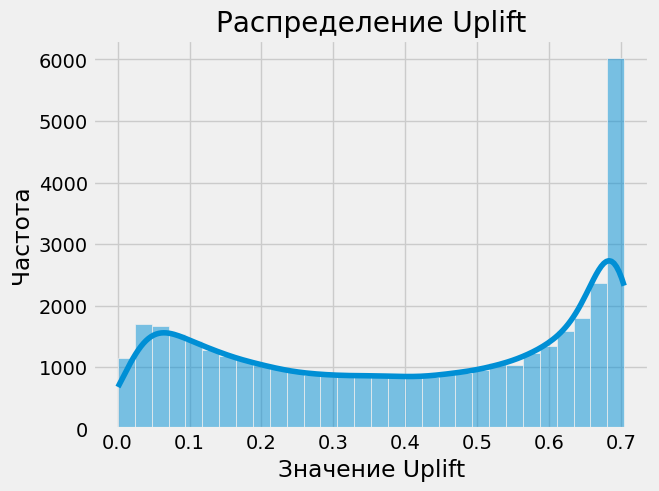

In [ ]:
plot_uplift_distribution(uplift_simple_solo_push)

In [ ]:
# считае для banner channel
uplift_simple_solo_banner = calculate_simple_solomodel_uplift(X_train_banner, X_test_banner, y_train_banner)

print(qini_auc_score(y_true=y_test_banner, uplift=uplift_simple_solo_banner.flatten(), treatment=X_test_banner['t_flag']))

0.19374897932592267


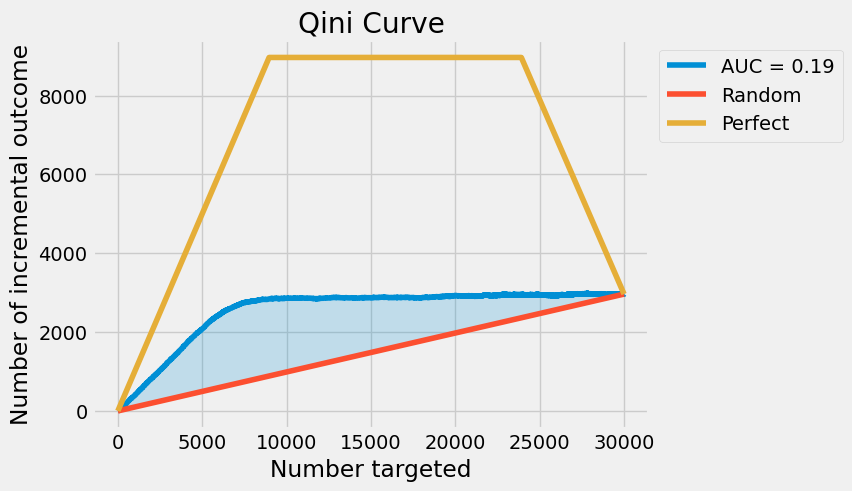

In [ ]:
# строим график для Banner Channel
plot_qini_curve(y_true=y_test_banner, uplift=uplift_simple_solo_banner.flatten(), treatment=X_test_banner['t_flag'])
plt.title("Qini Curve")
plt.show()

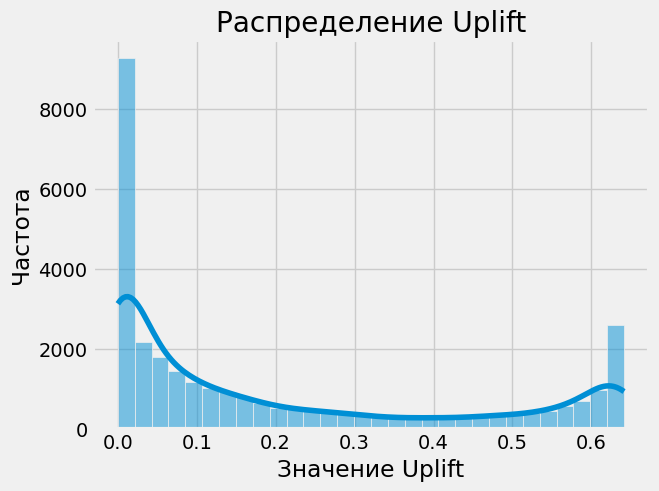

In [ ]:
plot_uplift_distribution(uplift_simple_solo_banner)

In [ ]:
# считаем для Other Ads Channe
uplift_simple_solo_other_ads = calculate_simple_solomodel_uplift(X_train_other_ads, X_test_other_ads, y_train_other_ads)

print(qini_auc_score(y_true=y_test_other_ads, uplift=uplift_simple_solo_other_ads.flatten(), treatment=X_test_other_ads['t_flag']))

0.20358752856399215


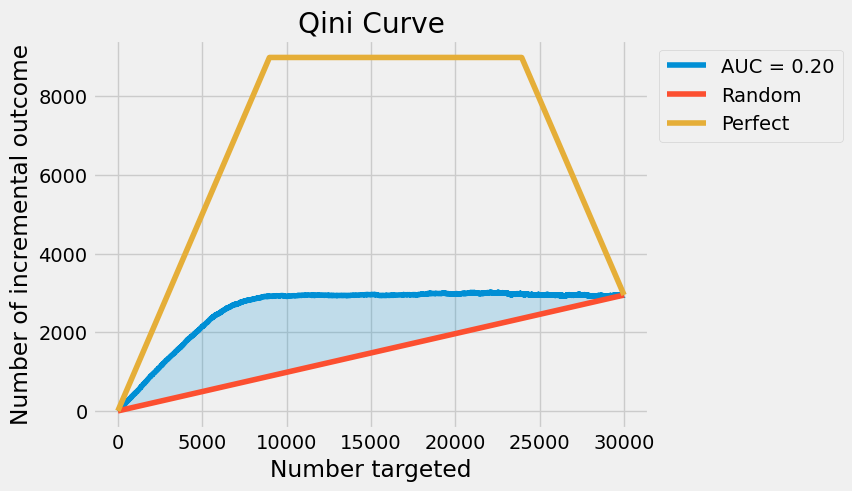

In [ ]:
# строим график для Other Ads Channe
plot_qini_curve(y_true=y_test_other_ads, uplift=uplift_simple_solo_other_ads.flatten(),treatment=X_test_other_ads['t_flag'])
plt.title("Qini Curve")
plt.show()

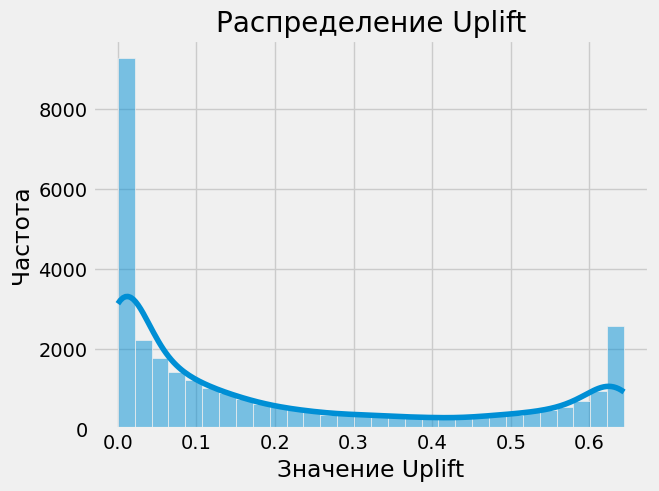

In [ ]:
plot_uplift_distribution(uplift_simple_solo_other_ads)

попробуем подобрать другие модели, данные низкого качества.


In [ ]:
from sklift.models import TwoModels

0.37700298113647274


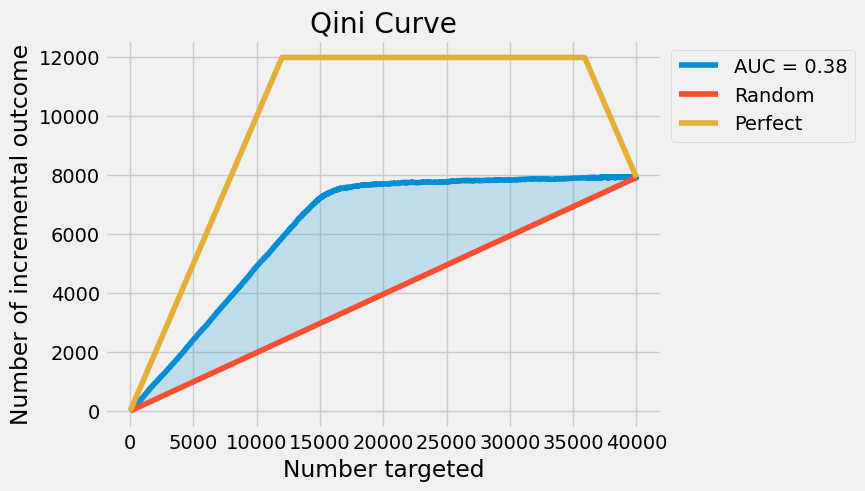

In [ ]:
# twomodels for Push
model_1 = LogisticRegression(random_state=42)
model_2 = LogisticRegression(random_state=52)

first_try = TwoModels(estimator_trmnt=model_1,
                       estimator_ctrl=model_2,
                       method='vanilla')

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model_uplift', first_try)
])


push_twomodel = pipeline.fit(X_train_push.drop(columns='t_flag'), y_train_push, model_uplift__treatment=X_train_push['t_flag'])

uplift_pred_push = push_twomodel.predict(X_test_push.drop(columns='t_flag'))

print(qini_auc_score(y_true=y_test_push, uplift=uplift_pred_push, treatment=X_test_push['t_flag']))

plot_qini_curve(y_true=y_test_push, uplift=uplift_pred_push, treatment=X_test_push['t_flag'])

plt.title("Qini Curve")
plt.show()

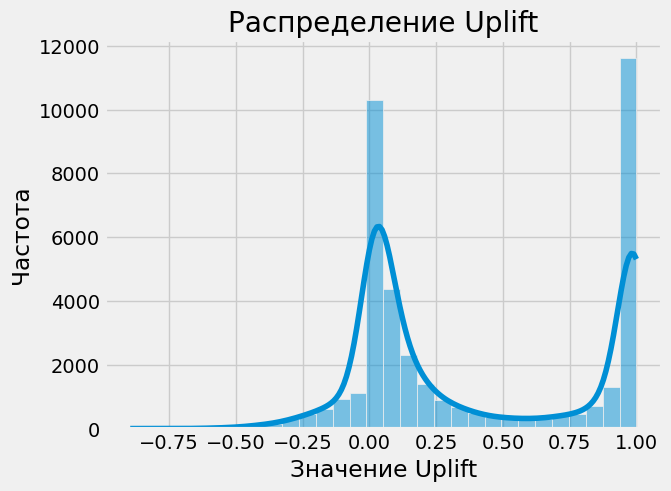

In [ ]:
plot_uplift_distribution(uplift_pred_push)

0.2086631500806544


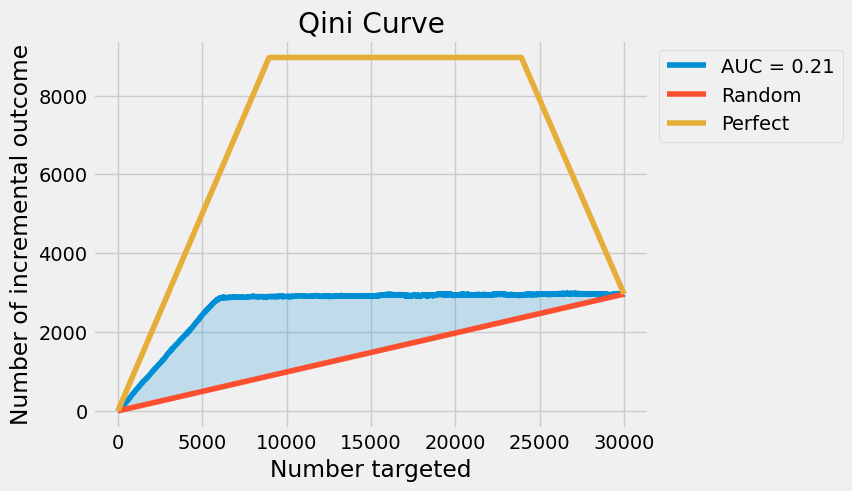

In [ ]:
# twomodels for Banner
model_1 = LogisticRegression(random_state=42)
model_2 = LogisticRegression(random_state=52)

first_try = TwoModels(estimator_trmnt=model_1,
                       estimator_ctrl=model_2,
                       method='vanilla')

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model_uplift', first_try)
])

banner_twomodel = pipeline.fit(X_train_banner.drop(columns='t_flag'), y_train_banner, model_uplift__treatment=X_train_banner['t_flag'])

uplift_pred_banner = banner_twomodel.predict(X_test_banner.drop(columns='t_flag'))

print(qini_auc_score(y_true=y_test_banner,
                             uplift=uplift_pred_banner,
                             treatment=X_test_banner['t_flag']))

plot_qini_curve(y_true=y_test_banner,
                uplift=uplift_pred_banner,
                treatment=X_test_banner['t_flag'])

plt.title("Qini Curve")
plt.show()

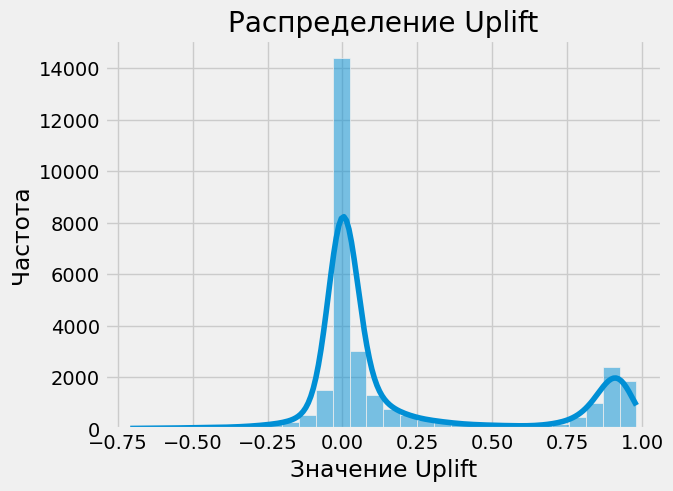

In [ ]:
plot_uplift_distribution(uplift_pred_banner)

0.21325124533368997


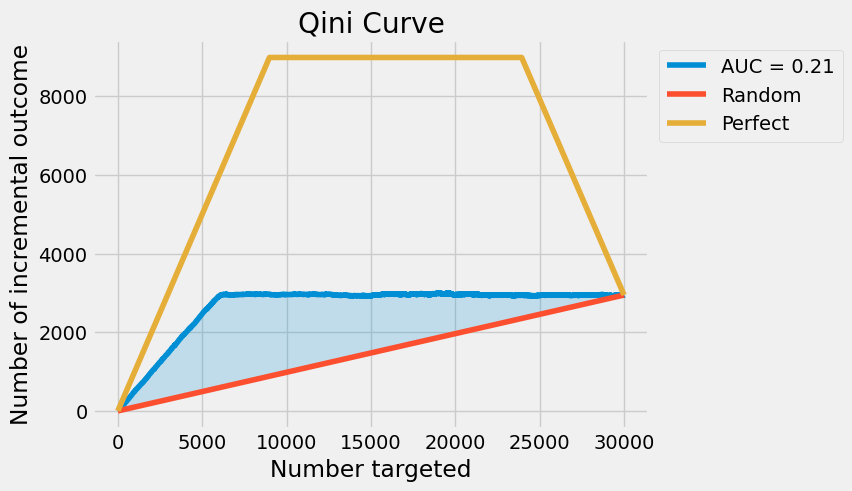

In [ ]:
# twomodels for Other Ads
model_1 = LogisticRegression(random_state=42)
model_2 = LogisticRegression(random_state=52)

first_try = TwoModels(estimator_trmnt=model_1,
                       estimator_ctrl=model_2,
                       method='vanilla')

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model_uplift', first_try)
])

other_ads_twomodel = pipeline.fit(X_train_other_ads.drop(columns='t_flag'), y_train_other_ads, model_uplift__treatment=X_train_other_ads['t_flag'])

uplift_pred_other_ads = other_ads_twomodel.predict(X_test_other_ads.drop(columns='t_flag'))

print(qini_auc_score(y_true=y_test_other_ads,
                             uplift=uplift_pred_other_ads,
                             treatment=X_test_other_ads['t_flag']))

plot_qini_curve(y_true=y_test_other_ads,
                uplift=uplift_pred_other_ads,
                treatment=X_test_other_ads['t_flag'])

plt.title("Qini Curve")
plt.show()

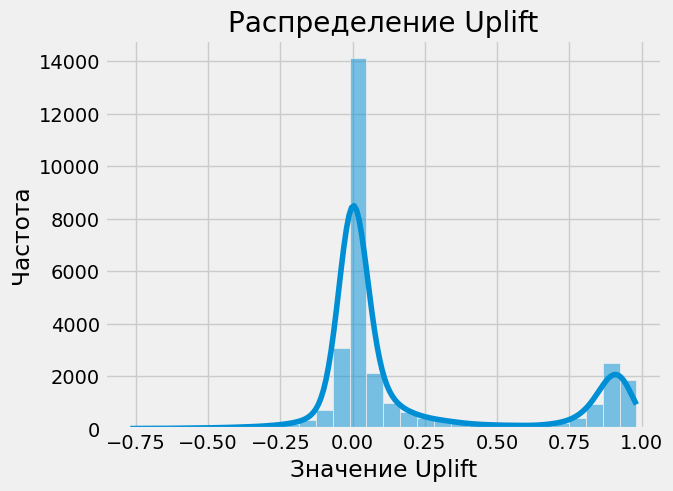

In [ ]:
plot_uplift_distribution(uplift_pred_other_ads)

Согласно графикам, мы апнули результат по моделькам

In [ ]:
# проведем калибровку через функции
def calculate_twomodel_uplift_calibrated(X_train, X_test, y_train, treatment_train, treatment_test, random_state=42):
    """
    делает калибровку для TwoModels
    """
    model_1 = LogisticRegression(random_state=random_state+1)
    model_2 = LogisticRegression(random_state=random_state+2)

    calibrated_model_1 = CalibratedClassifierCV(model_1, cv=5, method='isotonic')
    calibrated_model_2 = CalibratedClassifierCV(model_2, cv=5, method='isotonic')

    second_try = TwoModels(estimator_trmnt=calibrated_model_1, estimator_ctrl=calibrated_model_2, method='vanilla')

    second_try.fit(X_train.drop(columns='t_flag'), y_train, treatment=treatment_train)

    uplift_pred = second_try.predict(X_test.drop(columns='t_flag'))

    return uplift_pred

0.3784670834613485


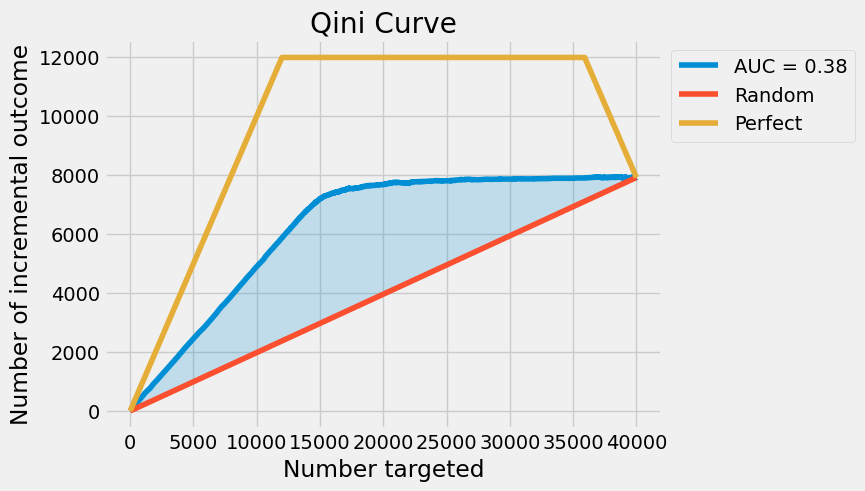

In [ ]:
# график для push colibrated
uplift_twomode_calibrated_push = calculate_twomodel_uplift_calibrated(X_train_push, X_test_push, y_train_push,  X_train_push['t_flag'], X_test_push['t_flag'])
print(qini_auc_score(y_true=y_test_push,  uplift=uplift_twomode_calibrated_push, treatment=X_test_push['t_flag']))

plot_qini_curve(y_true=y_test_push, uplift=uplift_twomode_calibrated_push, treatment=X_test_push['t_flag'])
plt.title("Qini Curve")
plt.show()

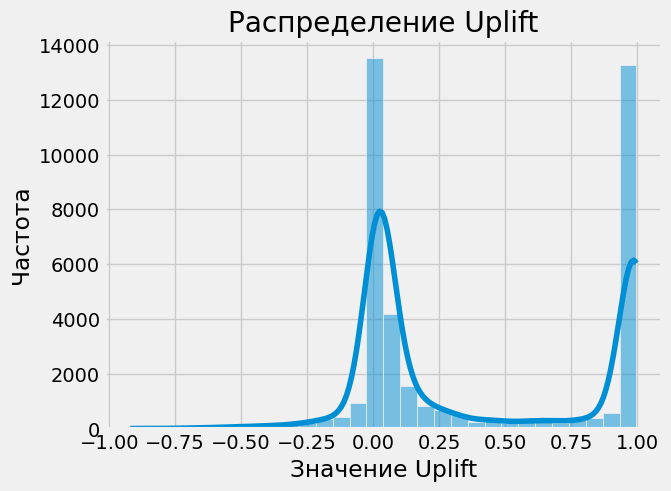

In [ ]:
plot_uplift_distribution(uplift_twomode_calibrated_push)

0.20883741318126783


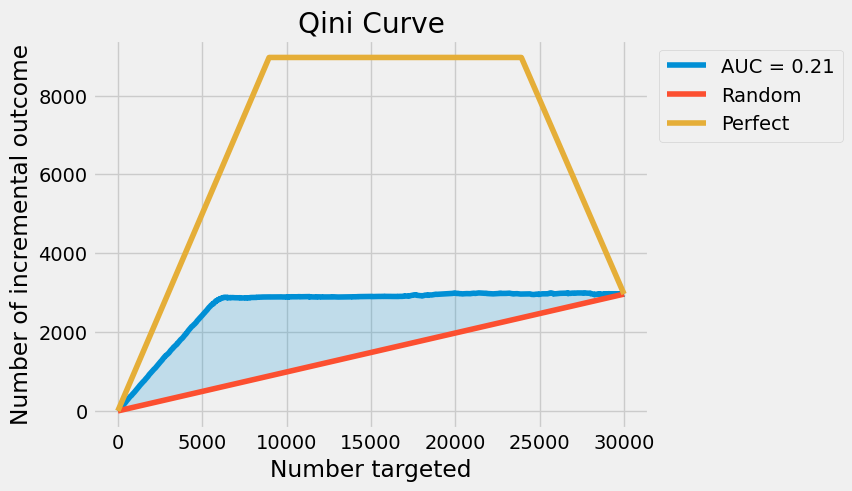

In [ ]:
# Использование функции для bammer channel и построение графика
uplift_twomode_calibrated_banner = calculate_twomodel_uplift_calibrated(X_train_banner, X_test_banner, y_train_banner, X_train_banner['t_flag'], X_test_banner['t_flag'])
print(qini_auc_score(y_true=y_test_banner, uplift=uplift_twomode_calibrated_banner, treatment=X_test_banner['t_flag']))

plot_qini_curve(y_true=y_test_banner, uplift=uplift_twomode_calibrated_banner, treatment=X_test_banner['t_flag'])
plt.title("Qini Curve")
plt.show()

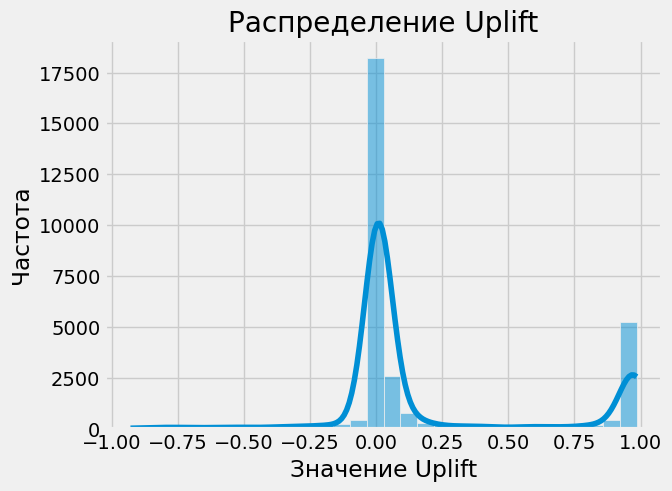

In [ ]:
plot_uplift_distribution(uplift_twomode_calibrated_banner)

0.2149692443855405


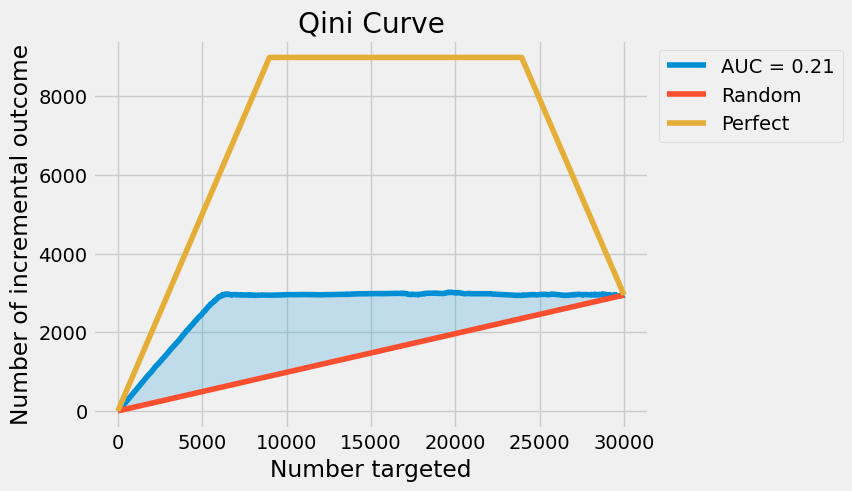

In [ ]:
# Использование функции для other ads channel и построение графика
uplift_twomode_calibrated_other_ads = calculate_twomodel_uplift_calibrated(X_train_other_ads, X_test_other_ads, y_train_other_ads, X_train_other_ads['t_flag'], X_test_other_ads['t_flag'])
print(qini_auc_score(y_true=y_test_other_ads, uplift=uplift_twomode_calibrated_other_ads, treatment=X_test_other_ads['t_flag']))

plot_qini_curve(y_true=y_test_other_ads, uplift=uplift_twomode_calibrated_other_ads, treatment=X_test_other_ads['t_flag'])
plt.title("Qini Curve")
plt.show()

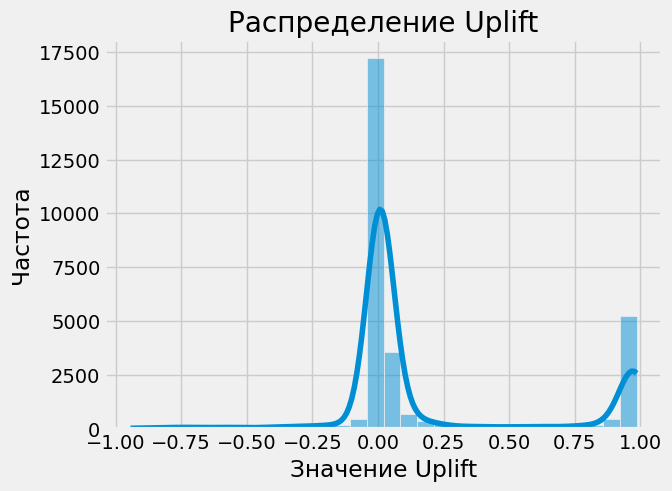

In [ ]:
plot_uplift_distribution(uplift_twomode_calibrated_other_ads)

Толком разницы нет никакой, может потому что логрег(?)

In [ ]:
from sklift.models import ClassTransformation
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# попробуем через ClassTransformation
def calculate_classtransformation_uplift(X_train, X_test, y_train, y_test, treatment_train):
    X_train = X_train.drop(columns=['t_flag'], errors='ignore')
    X_test = X_test.drop(columns=['t_flag'], errors='ignore')

    base_model = RandomForestClassifier(n_estimators=100, random_state=42)
    uplift_model = ClassTransformation(base_model)
    uplift_model.fit(X_train, y_train, treatment_train)
    uplift_preds = uplift_model.predict(X_test)

    return uplift_preds

0.3842906279059002


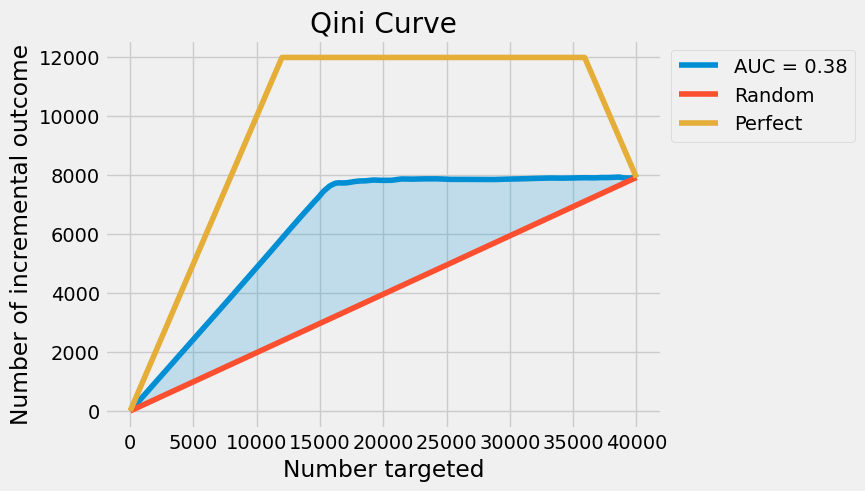

In [ ]:
# реализуем для push
uplift_classtransformation_push = calculate_classtransformation_uplift(X_train_push, X_test_push, y_train_push, y_test_push, X_train_push['t_flag'])
print(qini_auc_score(y_true=y_test_push, uplift=uplift_classtransformation_push, treatment=X_test_push['t_flag']))

plot_qini_curve(y_true=y_test_push, uplift=uplift_classtransformation_push, treatment=X_test_push['t_flag'])

plt.title("Qini Curve")
plt.show()

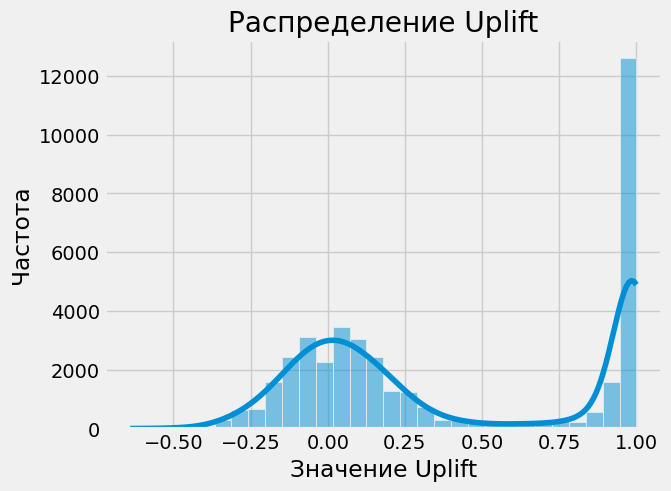

In [ ]:
plot_uplift_distribution(uplift_classtransformation_push)

0.20941263460653628


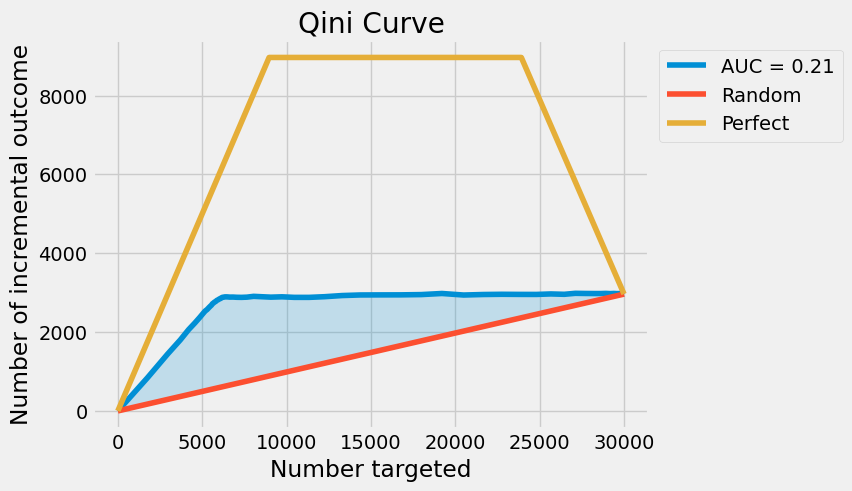

In [ ]:
# реализуем для Banner Channel и построим графики
uplift_classtransformation_banner = calculate_classtransformation_uplift(X_train_banner, X_test_banner, y_train_banner, y_test_banner, X_train_banner['t_flag'])
print(qini_auc_score(y_true=y_test_banner, uplift=uplift_classtransformation_banner, treatment=X_test_banner['t_flag']))

plot_qini_curve(y_true=y_test_banner, uplift=uplift_classtransformation_banner, treatment=X_test_banner['t_flag'])

plt.title("Qini Curve")
plt.show()

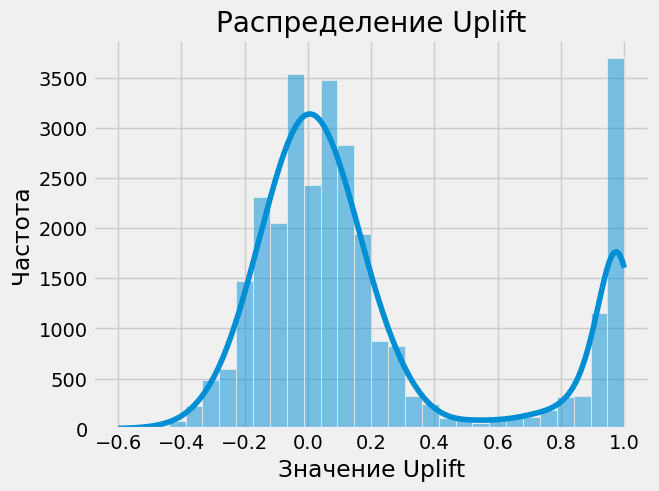

In [ ]:
plot_uplift_distribution(uplift_classtransformation_banner)

0.21324855389634403


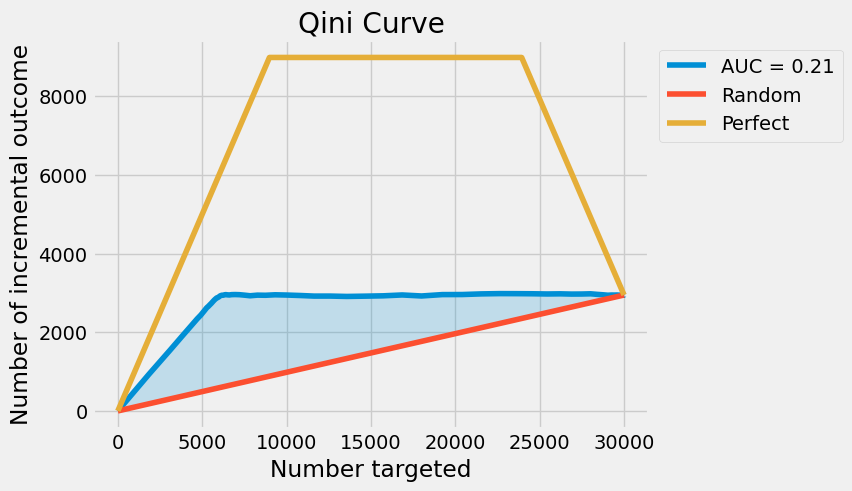

In [ ]:
# реализуем для Other Ads Channel и построим график
uplift_classtransformation_other_ads = calculate_classtransformation_uplift(X_train_other_ads, X_test_other_ads, y_train_other_ads, y_test_other_ads, X_train_other_ads['t_flag'])
print(qini_auc_score(y_true=y_test_other_ads, uplift=uplift_classtransformation_other_ads, treatment=X_test_other_ads['t_flag']))

plot_qini_curve(y_true=y_test_other_ads, uplift=uplift_classtransformation_other_ads, treatment=X_test_other_ads['t_flag'])

plt.title("Qini Curve")
plt.show()

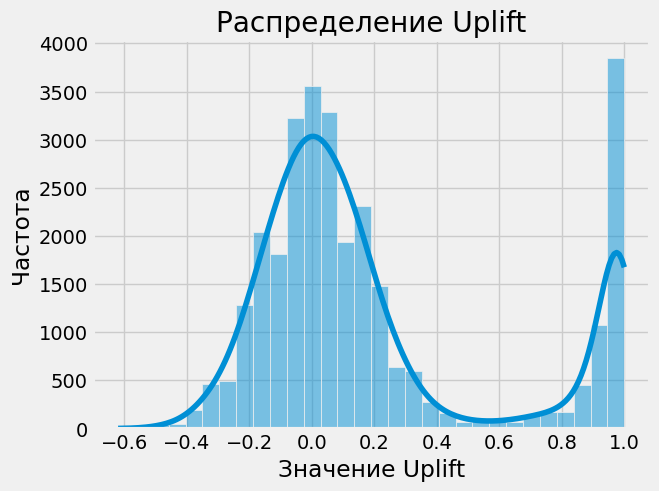

In [ ]:
plot_uplift_distribution(uplift_classtransformation_other_ads)

In [ ]:
# функйия для UpliftRandomForestClassifier
def calculate_rf_uplift(X_train, y_train, X_test, y_test, control_name='0', random_state=42):
    uplift_forest = UpliftRandomForestClassifier(control_name=control_name, random_state=random_state)

    X_train = X_train.copy()
    X_test = X_test.copy()

    X_train['t_flag'] = X_train['t_flag'].astype('float').astype('int').astype('str')
    X_test['t_flag'] = X_test['t_flag'].astype('float').astype('int').astype('str')

    uplift_forest.fit(X=X_train.drop(columns='t_flag').values, y=y_train.values, treatment=X_train['t_flag'].values)

    uplift_fr = uplift_forest.predict(X=X_test.drop(columns='t_flag').values)

    qini_score = qini_auc_score(y_true=y_test, uplift=uplift_fr.reshape(-1), treatment=X_test['t_flag'].astype('int'))

    plot_qini_curve(y_true=y_test, uplift=pd.Series(uplift_fr.reshape(-1), index=X_test.index), treatment=X_test['t_flag'].astype(int))
    plt.show()

    return qini_score

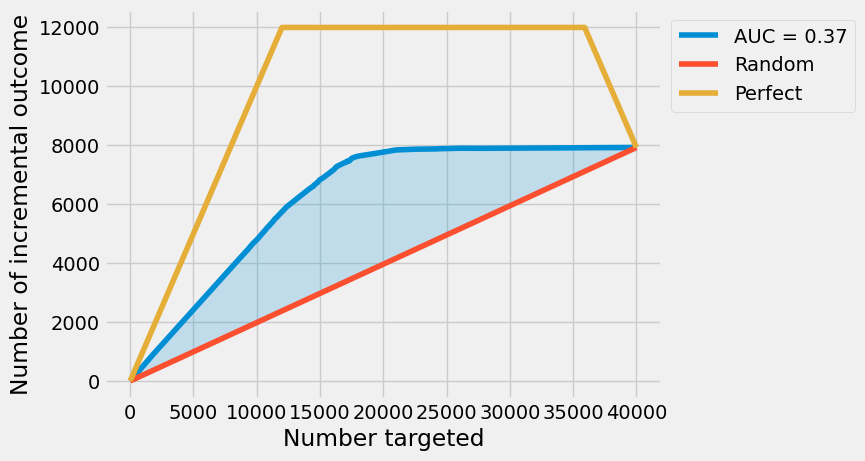

In [ ]:
uplift_push_random = calculate_rf_uplift(X_train_push, y_train_push, X_test_push, y_test_push)

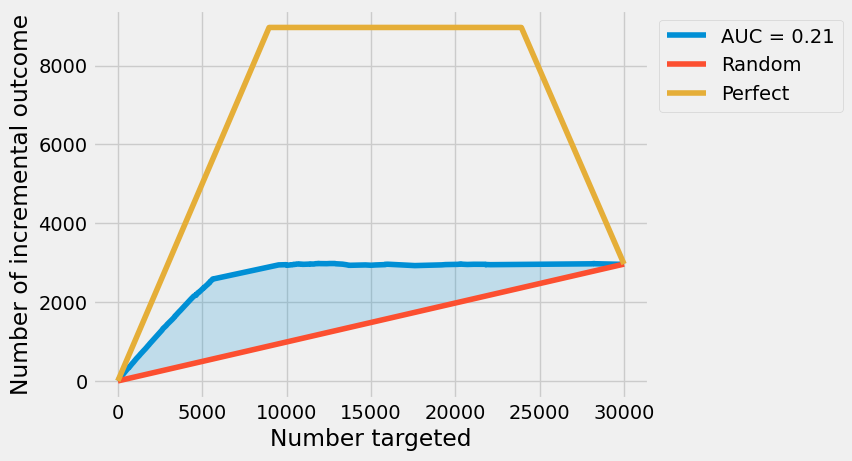

In [ ]:
uplift_banner_random = calculate_rf_uplift(X_train_banner, y_train_banner, X_test_banner, y_test_banner)

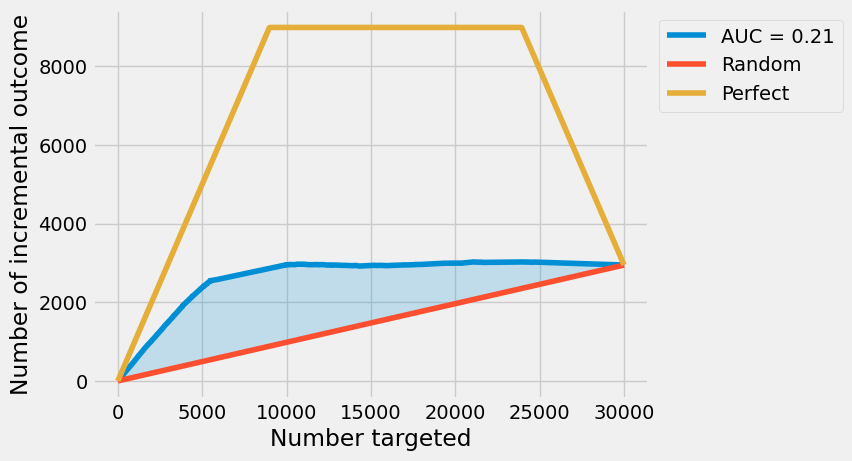

In [ ]:
upliftother_ads = calculate_rf_uplift(X_train_other_ads, y_train_other_ads, X_test_other_ads, y_test_other_ads)

Тюнингуем optune & gridserch

In [ ]:
# функция для тюнинга
random_state = 42
field = StratifiedKFold(n_splits=5,
                      random_state=random_state,
                      shuffle=True)

def objective_tm_lr(trial, X_train, y_train, field):
    param = {
            'C_1': trial.suggest_float("C_1", 0, 3),
            'C_2': trial.suggest_float("C_2", 0, 3),
            'method': trial.suggest_categorical("method", ['vanilla', 'ddr_control', 'ddr_treatment'])
    }

    model_1 = LogisticRegression(random_state=42, C=param['C_1'])
    model_2 = LogisticRegression(random_state=52, C=param['C_2'])

    forth_try = TwoModels(estimator_trmnt=model_1,
                   estimator_ctrl=model_2,
                   method=param['method'])

    pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                           ('model_uplift', forth_try)])

    qini_scorer = make_uplift_scorer("qini_auc_score", X_train['t_flag'])

    cross_val = cross_validate(pipe,
                               X=X_train.drop(columns='t_flag'),
                               y=y_train,
                               fit_params={'model_uplift__treatment': X_train['t_flag']},
                               scoring=qini_scorer,
                               cv=skf,
                               return_train_score=True)

    mean_score = cross_val['test_score'].mean()
    std_score = cross_val['test_score'].std()

    return mean_score - std_score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_tm_lr(trial, X_train_push, y_train_push, skf),
                  n_trials=500,
                  show_progress_bar=True)

best_params = study.best_params
print(best_params)

best_C_1 = best_params['C_1']
best_C_2 = best_params['C_2']
best_method = best_params['method']

model_1 = LogisticRegression(random_state=42, C=best_C_1)
model_2 = LogisticRegression(random_state=50, C=best_C_2)

forth_try = TwoModels(estimator_trmnt=model_1,
               estimator_ctrl=model_2,
               method=best_method)

pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                       ('model_uplift', forth_try)])

pipe.fit(X_train_push.drop(columns='t_flag'),
         y_train_push,
         model_uplift__treatment=X_train_push['t_flag'])

y_pred_uplift = pipe.predict(X_test_push.drop(columns='t_flag'))

qini_score = qini_auc_score(y_test_push, y_pred_uplift, X_test_push['t_flag'])
print(f'Qini AUC: {qini_score}')

[I 2025-03-12 10:34:20,132] A new study created in memory with name: no-name-c8a4b372-f4da-4519-87fb-b7c119da64f9


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-03-12 10:34:22,570] Trial 0 finished with value: 0.377593835074821 and parameters: {'C_1': 0.5024582343464044, 'C_2': 2.412229241970729, 'method': 'vanilla'}. Best is trial 0 with value: 0.377593835074821.
[I 2025-03-12 10:34:25,861] Trial 1 finished with value: 0.37834458423715617 and parameters: {'C_1': 1.3073377380726052, 'C_2': 0.842877772578183, 'method': 'vanilla'}. Best is trial 1 with value: 0.37834458423715617.
[I 2025-03-12 10:34:28,592] Trial 2 finished with value: 0.37828272458960216 and parameters: {'C_1': 1.993776100667621, 'C_2': 2.270899000412217, 'method': 'ddr_treatment'}. Best is trial 1 with value: 0.37834458423715617.
[I 2025-03-12 10:34:31,179] Trial 3 finished with value: 0.3782032146849274 and parameters: {'C_1': 1.6526319677871086, 'C_2': 2.6762941956786745, 'method': 'ddr_treatment'}. Best is trial 1 with value: 0.37834458423715617.
[I 2025-03-12 10:34:33,396] Trial 4 finished with value: 0.3780242580081994 and parameters: {'C_1': 0.7376941346768395, '

Qini AUC: 0.38404298912681895

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [ ]:
# подобьем данные для предсказаний
col = names + ['user_id']
prediction = aggs[aggs["report_dt"] == '2025-01-01'][col]

In [ ]:
prediction.head()

x1        x2        x3        x4        x5        x6        x7  \
104548  0.654343 -1.439286 -0.011475  2.039457  0.843580 -0.977480 -0.768019   
404628  0.238281 -1.221378  0.338246  2.578613 -0.738267 -0.293309 -1.623151   
129453  1.262071 -0.590011 -1.487096 -0.966672  2.740715  0.312791 -0.356535   
281997 -6.942073  0.107627  1.760962  4.424731  1.980637  0.238544 -1.329872   
326691 -2.200147  0.694959 -1.620087  4.003986  0.808261  0.214216 -0.330887   

              x8        x9  age  user_id  
104548 -1.044127  0.025673   26  1066338  
404628 -0.419945 -0.285695   42    25872  
129453 -0.539563  1.401530   28  4107442  
281997  0.288694 -1.625620   32  2047420  
326691 -1.386118  1.525752   22  1120643

In [ ]:
prediction.tail()

x1        x2        x3        x4        x5        x6        x7  \
291841 -0.852355  2.184957 -0.798753  1.716976 -0.200655 -1.836446 -0.407546   
90056   1.343056  0.408401 -2.688668 -0.235793 -2.562377 -0.119657 -1.866503   
250338 -0.999208  0.527982 -2.094625  2.747209  2.326767  0.237984 -1.318151   
342943 -1.970020  1.180142 -0.572525  1.052022 -0.654687  0.744590 -2.342623   
454256  0.289840  1.089333 -1.081154  0.259124 -1.985497  1.429450 -2.007802   

              x8        x9  age  user_id  
291841 -1.819025  0.756988   36  4034876  
90056   0.273952  2.557688   31   114148  
250338 -1.509199  1.989945   39   143255  
342943 -0.136155  0.582400   40   132172  
454256 -0.091926  1.052896   45  2059711

In [ ]:
# юзаем модель twomodels
prediction_push = push_twomodel.predict(prediction.drop(columns='user_id'))
prediction_banner = banner_twomodel.predict(prediction.drop(columns='user_id'))
prediction_other_ads = other_ads_twomodel.predict(prediction.drop(columns=['x5', 'user_id']))

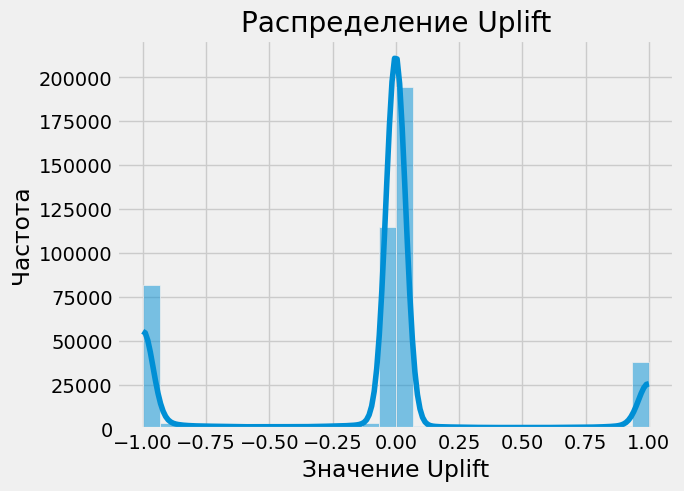

In [ ]:
plot_uplift_distribution(prediction_push)

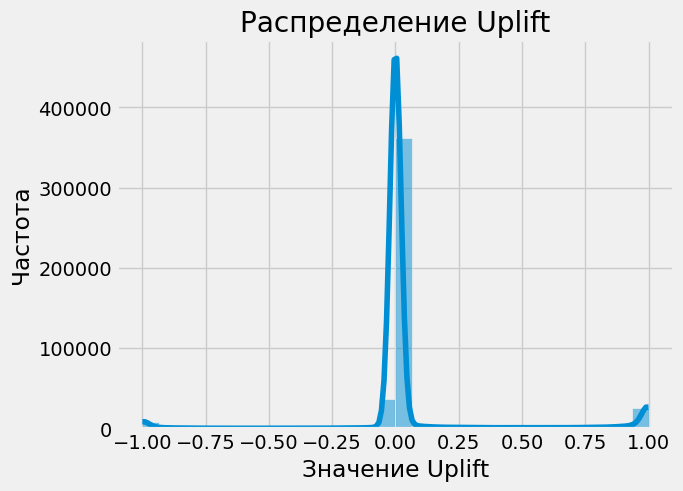

In [ ]:
plot_uplift_distribution(prediction_banner)

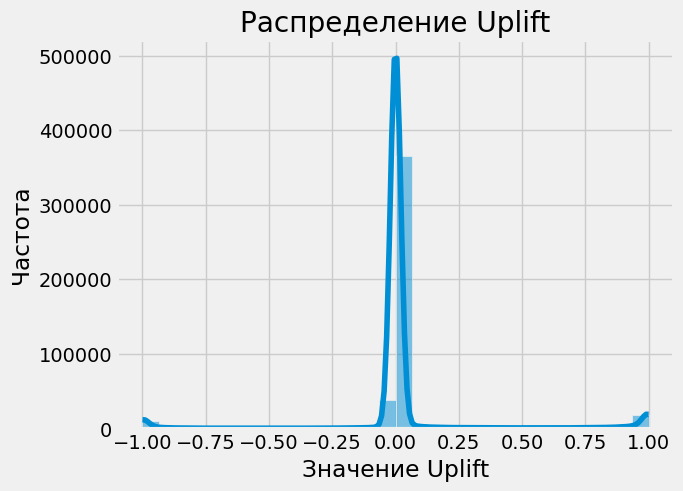

In [ ]:
plot_uplift_distribution(prediction_other_ads)

In [ ]:
prediction["predict_push"] = prediction_push
prediction["predict_banner"] = prediction_banner
prediction["predict_other_ads"] = prediction_other_ads
prediction.head()

x1        x2        x3        x4        x5        x6        x7  \
104548  0.654343 -1.439286 -0.011475  2.039457  0.843580 -0.977480 -0.768019   
404628  0.238281 -1.221378  0.338246  2.578613 -0.738267 -0.293309 -1.623151   
129453  1.262071 -0.590011 -1.487096 -0.966672  2.740715  0.312791 -0.356535   
281997 -6.942073  0.107627  1.760962  4.424731  1.980637  0.238544 -1.329872   
326691 -2.200147  0.694959 -1.620087  4.003986  0.808261  0.214216 -0.330887   

              x8        x9  age  user_id  predict_push  predict_banner  \
104548 -1.044127  0.025673   26  1066338 -9.999922e-01    2.884474e-04   
404628 -0.419945 -0.285695   42    25872  0.000000e+00    6.568877e-11   
129453 -0.539563  1.401530   28  4107442  5.212450e-18    1.137931e-02   
281997  0.288694 -1.625620   32  2047420  0.000000e+00    1.077727e-23   
326691 -1.386118  1.525752   22  1120643 -1.877910e-06    0.000000e+00   

        predict_other_ads  
104548       3.364106e-04  
404628       5.154605e-11  
129453       3.238344e-04  
281997       4.585589e-23  
326691       0.000000e+00

In [ ]:
# Добавим столбцы channel и uplift
prediction["uplift"] = prediction[["predict_push", "predict_banner", "predict_other_ads"]].max(axis=1)
prediction["channel"] = prediction[["predict_push", "predict_banner", "predict_other_ads"]].idxmax(axis=1)

In [ ]:
prediction = prediction[['user_id', 'uplift', 'channel']]

In [ ]:
# если uplift >= 0 то высыплаем расслыки
prediction.loc[:, "channel"] = prediction["channel"].str.replace("predict_", "", regex=False)
prediction.loc[:, "channel"] = prediction["channel"].where(prediction["uplift"] > 0, "no_comm")
prediction.head()

user_id        uplift    channel
104548  1066338  3.364106e-04  other_ads
404628    25872  6.568877e-11     banner
129453  4107442  1.137931e-02     banner
281997  2047420  4.585589e-23  other_ads
326691  1120643  0.000000e+00    no_comm

In [ ]:
# если uplift >= 0
prediction['channel'].value_counts()

channel
no_comm      168048
banner       139513
push         112081
other_ads     40358
Name: count, dtype: int64

если uplift >= 0 то все рассылки придут для половины


Положиительный рещзульта напрямую зависит от значения аплифта, чем он выше, тем вероятноть положительного результата больше.

Как выриант, аплифт весь застратное приспособление и более рентабельно его спользовать для топ клиентов той или иной компании, как напоминалка, так мы можем привлечь клиентов к тем или иным действиям, тем самым увеличим нашу прибыль и повысят эффективность компании

In [ ]:
# топ 30 процентов клинетов наших компаний
top_30 = prediction.nlargest(int(len(prediction) * 0.30), 'uplift')
prediction.loc[~prediction.index.isin(top_20.index), "channel"] = "no_comm"
prediction.head()

user_id        uplift  channel
104548  1066338  3.364106e-04  no_comm
404628    25872  6.568877e-11  no_comm
129453  4107442  1.137931e-02  no_comm
281997  2047420  4.585589e-23  no_comm
326691  1120643  0.000000e+00  no_comm

In [ ]:
# для 30 процентов клиентов
prediction['channel'].value_counts()

channel
no_comm      368000
push          47844
banner        31723
other_ads     12433
Name: count, dtype: int64

На основе проведенного исследования были разработаны и протестированы несколько методов uplift-моделирования. При использовании различных подходов, основанных на логистической регрессии, показатели качества моделей по метрике qini_auc_score продемонстрировали схожие результаты. Все разработанные модели превзошли по эффективности базовый вариант с самостоятельной реализацией SoloModel.

В рамках эксперимента для одного из каналов взаимодействия (push-уведомления) была выполнена оптимизация гиперпараметров с помощью библиотеки Optuna. Однако применение данной методики к логистической регрессии не привело к значительному улучшению результатов.

Анализ проводился на данных за январь, а прогнозирование осуществлялось для кампаний в марте. Оценка эффективности проводилась по трем основным каналам коммуникации: push-уведомления, баннеры и прочие рекламные форматы. Канал SMS-информирования был исключен из анализа после проведения исследовательского анализа данных (EDA), который выявил технические проблемы в работе данного канала.

При формировании стратегий коммуникаций были рассмотрены следующие подходы:

• Полная сегментация пользователей с положительным эффектом от взаимодействия (uplift > 0). В этом случае наибольший охват обеспечивает использование баннерной рекламы.

• Точечные коммуникации с топ-30% пользователей, демонстрирующих максимальный эффект от взаимодействия. В данном сценарии наиболее успешным оказался канал push-уведомлений.

Дополнительно стоит отметить, что внедрение uplift-моделирования может принести дополнительные преимущества бизнесу:

Оптимизация бюджета маркетинговых кампаний за счет исключения затрат на неперспективных пользователей
Повышение качества взаимодействия с клиентами благодаря персонализированному подходу
Снижение риска "маркетинговой усталости" пользователей от нерелевантных сообщений
Возможность более точного прогнозирования ROI маркетинговых активностей
Улучшение общей стратегии взаимодействия с пользователями путем выявления наиболее эффективных каналов коммуникации
Эти факторы могут существенно повысить общую эффективность маркетинговых кампаний и улучшить показатели удержания клиентов.
